In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.1 MB/s eta 0:00:00


In [ ]:
!pip install folium

In [ ]:
!pip install plotly


In this section, I imported essential Python libraries for data analysis, visualization, and machine learning.

- **pandas** and **numpy**: For data manipulation.
- **matplotlib** and **seaborn**: For data visualization.
- **scikit-learn** models and tools: For building classification models.
- **catboost**, **lightGBM**, and **imbalanced-learn (SMOTE)**: For boosting and handling imbalanced data.
- I also disabled warnings to keep the notebook clean and readable.

This setup helps me provide a comprehensive base for performing advanced EDA, preprocessing, and model development.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import plotly.express as px

#Model Import
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Model Evaluation
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

import pickle
import shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

To conduct a geographically diverse and insightful analysis of air quality, I selected five representative monitoring sites across different regions of Beijing. These stations were chosen to cover a range of environmental and socio-economic conditions, which helps in understanding how pollution levels vary across urban, rural, and industrial landscapes.

- **Aotizhongxin (Industrial)**: This site is located near Beijing’s Olympic Sports Center, a zone that also includes dense traffic and industrial activity. Including this station provides insights into pollution in high-activity urban-industrial zones.

- **Dongsi (Urban)**: Located in the city center, Dongsi is a densely populated urban area with heavy traffic. It helps to analyze typical urban pollution levels where population exposure is highest.

- **Changping (Suburban)**: Positioned at the edge of urban expansion, Changping is undergoing rapid residential and commercial development. It offers a middle ground between urban and rural, useful for detecting early signs of pollution creep from the city.

- **Huairou (Rural)**: This site is in a mountainous area with low human activity and fewer pollution sources. It serves as a baseline for comparing air quality in less polluted, greener regions.

- **Shunyi (Semi-Rural / Airport Zone)**: Shunyi is located near Beijing Capital Airport and is less densely populated, yet influenced by aircraft emissions and suburban transport. It provides a unique perspective on non-industrial, transport-related pollution in outer zones.

## 📌 Why These Sites? (Geographical Disadvantage)

This **diverse selection** allows meaningful analysis of how **air pollution varies by land use**, traffic intensity, and local development. Research shows that **urban-industrial regions** experience consistently higher pollutant concentrations due to mixed sources (Zhang et al., 2015). Meanwhile, **rural and suburban areas** act as comparators to highlight disparities caused by infrastructure, wind flow, and emissions control.

> **Reference**:  
Zhang, Y.-L. and Cao, F. (2015) ‘Fine particulate matter (PM 2.5 ) in China at a city level’, Scientific Reports, 5(1), pp. 1–12. Available at: https://doi.org/10.1038/srep14884.


In [ ]:
df_aoti = pd.read_csv('/content/PRSA_Data_Aotizhongxin_20130301-20170228.csv')
df_changping = pd.read_csv('/content/PRSA_Data_Changping_20130301-20170228.csv')
df_dongsi = pd.read_csv('/content/PRSA_Data_Dongsi_20130301-20170228.csv')
df_huairou = pd.read_csv('/content/PRSA_Data_Huairou_20130301-20170228.csv')
df_shunyi = pd.read_csv('/content/PRSA_Data_Shunyi_20130301-20170228.csv')

After loading the five selected air quality datasets, I added two new columns to each of them:

1. `station` – to identify which monitoring site the data is from.
2. `area_type` – to categorize each station based on its location (e.g., Urban, Rural, Industrial, etc.).

Once the columns were added, I merged all the individual datasets into one using `pd.concat()`. This allowed me to work with one big DataFrame instead of multiple files. I also dropped the `No` column since it was just an index and didn’t add any value to the analysis.

By combining everything into a single DataFrame called `df`, I now have a clean, organized dataset that covers a variety of regions in Beijing. This makes it easier to compare how air pollution and weather conditions change based on where the station is located. It also sets things up nicely for grouped analysis and modeling later on.



In [ ]:
# Add station name
df_aoti['station'] = 'Aotizhongxin'
df_changping['station'] = 'Changping'
df_dongsi['station'] = 'Dongsi'
df_huairou['station'] = 'Huairou'
df_shunyi['station'] = 'Shunyi'

To perform meaningful geographical analysis, I added a new column called `area_type` to each station's dataset.

This column labels each station according to its location type:
- Urban
- Rural
- Suburban
- Industrial
- Semi-Rural

This will allow me to group and compare pollution levels and weather patterns based on location type, making the analysis more insightful and structured. It also prepares the data for grouped visualizations and modeling later on.


In [ ]:
# Add area type (geographic context)
df_aoti['area_type'] = 'Industrial'
df_changping['area_type'] = 'Suburban'
df_dongsi['area_type'] = 'Urban'
df_huairou['area_type'] = 'Rural'
df_shunyi['area_type'] = 'Semi-Rural'

In [ ]:
# Combine all into one DataFrame
df = pd.concat([df_aoti, df_changping, df_dongsi, df_huairou, df_shunyi], ignore_index=True)

In [ ]:


df.head(10)

No  year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  TEMP  \
0   1  2013      3    1     0    4.0   4.0   4.0   7.0  300.0  77.0  -0.7   
1   2  2013      3    1     1    8.0   8.0   4.0   7.0  300.0  77.0  -1.1   
2   3  2013      3    1     2    7.0   7.0   5.0  10.0  300.0  73.0  -1.1   
3   4  2013      3    1     3    6.0   6.0  11.0  11.0  300.0  72.0  -1.4   
4   5  2013      3    1     4    3.0   3.0  12.0  12.0  300.0  72.0  -2.0   
5   6  2013      3    1     5    5.0   5.0  18.0  18.0  400.0  66.0  -2.2   
6   7  2013      3    1     6    3.0   3.0  18.0  32.0  500.0  50.0  -2.6   
7   8  2013      3    1     7    3.0   6.0  19.0  41.0  500.0  43.0  -1.6   
8   9  2013      3    1     8    3.0   6.0  16.0  43.0  500.0  45.0   0.1   
9  10  2013      3    1     9    3.0   8.0  12.0  28.0  400.0  59.0   1.2   

     PRES  DEWP  RAIN   wd  WSPM       station   area_type  
0  1023.0 -18.8   0.0  NNW   4.4  Aotizhongxin  Industrial  
1  1023.2 -18.2   0.0    N   4.7  Aotizhongxin  Industrial  
2  1023.5 -18.2   0.0  NNW   5.6  Aotizhongxin  Industrial  
3  1024.5 -19.4   0.0   NW   3.1  Aotizhongxin  Industrial  
4  1025.2 -19.5   0.0    N   2.0  Aotizhongxin  Industrial  
5  1025.6 -19.6   0.0    N   3.7  Aotizhongxin  Industrial  
6  1026.5 -19.1   0.0  NNE   2.5  Aotizhongxin  Industrial  
7  1027.4 -19.1   0.0  NNW   3.8  Aotizhongxin  Industrial  
8  1028.3 -19.2   0.0  NNW   4.1  Aotizhongxin  Industrial  
9  1028.5 -19.3   0.0    N   2.6  Aotizhongxin  Industrial

In [ ]:
df.shape

(175320, 19)

In [ ]:
coords = {
    'Aotizhongxin': [39.982, 116.397],
    'Dongsi': [39.929, 116.417],
    'Changping': [40.218, 116.231],
    'Huairou': [40.317, 116.637],
    'Shunyi': [40.125, 116.655],
}

# Add lat/lon to the DataFrame
df['lat'] = df['station'].map(lambda x: coords[x][0])
df['lon'] = df['station'].map(lambda x: coords[x][1])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175320 entries, 0 to 175319
Data columns (total 21 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   No         175320 non-null  int64  
 1   year       175320 non-null  int64  
 2   month      175320 non-null  int64  
 3   day        175320 non-null  int64  
 4   hour       175320 non-null  int64  
 5   PM2.5      171005 non-null  float64
 6   PM10       172142 non-null  float64
 7   SO2        170818 non-null  float64
 8   NO2        169025 non-null  float64
 9   CO         165226 non-null  float64
 10  O3         169693 non-null  float64
 11  TEMP       175125 non-null  float64
 12  PRES       175126 non-null  float64
 13  DEWP       175120 non-null  float64
 14  RAIN       175123 non-null  float64
 15  wd         174236 non-null  object 
 16  WSPM       175156 non-null  float64
 17  station    175320 non-null  object 
 18  area_type  175320 non-null  object 
 19  lat        175320 non-n

In [ ]:
# Drop the 'No' column if it exists
df.drop(['No'],axis=1,inplace=True, errors='ignore')


In [ ]:
# View sample rows
df[['station', 'area_type']].drop_duplicates()

station   area_type
0       Aotizhongxin  Industrial
35064      Changping    Suburban
70128         Dongsi       Urban
105192       Huairou       Rural
140256        Shunyi  Semi-Rural

In [ ]:
df.head(10)

year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  TEMP    PRES  \
0  2013      3    1     0    4.0   4.0   4.0   7.0  300.0  77.0  -0.7  1023.0   
1  2013      3    1     1    8.0   8.0   4.0   7.0  300.0  77.0  -1.1  1023.2   
2  2013      3    1     2    7.0   7.0   5.0  10.0  300.0  73.0  -1.1  1023.5   
3  2013      3    1     3    6.0   6.0  11.0  11.0  300.0  72.0  -1.4  1024.5   
4  2013      3    1     4    3.0   3.0  12.0  12.0  300.0  72.0  -2.0  1025.2   
5  2013      3    1     5    5.0   5.0  18.0  18.0  400.0  66.0  -2.2  1025.6   
6  2013      3    1     6    3.0   3.0  18.0  32.0  500.0  50.0  -2.6  1026.5   
7  2013      3    1     7    3.0   6.0  19.0  41.0  500.0  43.0  -1.6  1027.4   
8  2013      3    1     8    3.0   6.0  16.0  43.0  500.0  45.0   0.1  1028.3   
9  2013      3    1     9    3.0   8.0  12.0  28.0  400.0  59.0   1.2  1028.5   

   DEWP  RAIN   wd  WSPM       station   area_type     lat      lon  
0 -18.8   0.0  NNW   4.4  Aotizhongxin  Industrial  39.982  116.397  
1 -18.2   0.0    N   4.7  Aotizhongxin  Industrial  39.982  116.397  
2 -18.2   0.0  NNW   5.6  Aotizhongxin  Industrial  39.982  116.397  
3 -19.4   0.0   NW   3.1  Aotizhongxin  Industrial  39.982  116.397  
4 -19.5   0.0    N   2.0  Aotizhongxin  Industrial  39.982  116.397  
5 -19.6   0.0    N   3.7  Aotizhongxin  Industrial  39.982  116.397  
6 -19.1   0.0  NNE   2.5  Aotizhongxin  Industrial  39.982  116.397  
7 -19.1   0.0  NNW   3.8  Aotizhongxin  Industrial  39.982  116.397  
8 -19.2   0.0  NNW   4.1  Aotizhongxin  Industrial  39.982  116.397  
9 -19.3   0.0    N   2.6  Aotizhongxin  Industrial  39.982  116.397

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175320 entries, 0 to 175319
Data columns (total 20 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   year       175320 non-null  int64  
 1   month      175320 non-null  int64  
 2   day        175320 non-null  int64  
 3   hour       175320 non-null  int64  
 4   PM2.5      171005 non-null  float64
 5   PM10       172142 non-null  float64
 6   SO2        170818 non-null  float64
 7   NO2        169025 non-null  float64
 8   CO         165226 non-null  float64
 9   O3         169693 non-null  float64
 10  TEMP       175125 non-null  float64
 11  PRES       175126 non-null  float64
 12  DEWP       175120 non-null  float64
 13  RAIN       175123 non-null  float64
 14  wd         174236 non-null  object 
 15  WSPM       175156 non-null  float64
 16  station    175320 non-null  object 
 17  area_type  175320 non-null  object 
 18  lat        175320 non-null  float64
 19  lon        175320 non-n

#EDA

In [ ]:
print("Dataset Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())

Dataset Shape: (175320, 20)

Data Types:
 year           int64
month          int64
day            int64
hour           int64
PM2.5        float64
PM10         float64
SO2          float64
NO2          float64
CO           float64
O3           float64
TEMP         float64
PRES         float64
DEWP         float64
RAIN         float64
wd            object
WSPM         float64
station       object
area_type     object
lat          float64
lon          float64
dtype: object

Missing Values:
 year             0
month            0
day              0
hour             0
PM2.5         4315
PM10          3178
SO2           4502
NO2           6295
CO           10094
O3            5627
TEMP           195
PRES           194
DEWP           200
RAIN           197
wd            1084
WSPM           164
station          0
area_type        0
lat              0
lon              0
dtype: int64


In [ ]:
df['wd'].unique()

array(['NNW', 'N', 'NW', 'NNE', 'ENE', 'E', 'NE', 'W', 'SSW', 'WSW', 'SE',
       'WNW', 'SSE', 'ESE', 'S', 'SW', nan], dtype=object)

In [ ]:
df['wd'].value_counts()

wd
NE     16004
NW     15553
N      12952
ENE    12558
NNE    12519
WNW    12252
E      11911
NNW    11377
ESE    10608
SE      9822
SW      9490
SSE     8813
S       8492
SSW     8113
WSW     6890
W       6882
Name: count, dtype: int64

In [ ]:
df['station'].unique()

array(['Aotizhongxin', 'Changping', 'Dongsi', 'Huairou', 'Shunyi'],
      dtype=object)

In [ ]:
df['station'].value_counts()

station
Aotizhongxin    35064
Changping       35064
Dongsi          35064
Huairou         35064
Shunyi          35064
Name: count, dtype: int64

In [ ]:
df['area_type'].value_counts()

area_type
Industrial    35064
Suburban      35064
Urban         35064
Rural         35064
Semi-Rural    35064
Name: count, dtype: int64

In [ ]:
df['PM2.5'] = df.groupby('area_type')['PM2.5'].transform(lambda x: x.fillna(x.median()))

# 🗺️ Interactive Map of Air Quality Stations Using Folium

To provide a **visual understanding** of how air pollution varies geographically, I used `Folium` to create an interactive map of the five selected stations.

Each station is shown as a circle marker, color-coded by PM2.5 pollution level:

- 🟢 **Green**: PM2.5 <= 35 (Low)
- 🟠 **Orange**: PM2.5 <= 75 (Medium)
- 🔴 **Red**: PM2.5 > 75 μg/m³ (High)

This map offers an intuitive, spatial overview of air quality **disparities** between industrial, urban, suburban, and rural regions.



In [ ]:
df['PM2.5'] = df['PM2.5'].fillna(df['PM2.5'].median())

def categorize_pm25(value):
    if pd.isna(value):
        return 'Unknown'
    elif value <= 35:
        return 'Low'
    elif value <= 75:
        return 'Medium'
    else:
        return 'High'

df['PM2.5_category'] = df['PM2.5'].apply(categorize_pm25)

In [ ]:
df.head(3)

year  month  day  hour  PM2.5  PM10  SO2   NO2     CO    O3  ...    PRES  \
0  2013      3    1     0    4.0   4.0  4.0   7.0  300.0  77.0  ...  1023.0   
1  2013      3    1     1    8.0   8.0  4.0   7.0  300.0  77.0  ...  1023.2   
2  2013      3    1     2    7.0   7.0  5.0  10.0  300.0  73.0  ...  1023.5   

   DEWP  RAIN   wd WSPM       station   area_type     lat      lon  \
0 -18.8   0.0  NNW  4.4  Aotizhongxin  Industrial  39.982  116.397   
1 -18.2   0.0    N  4.7  Aotizhongxin  Industrial  39.982  116.397   
2 -18.2   0.0  NNW  5.6  Aotizhongxin  Industrial  39.982  116.397   

   PM2.5_category  
0             Low  
1             Low  
2             Low  

[3 rows x 21 columns]

In [ ]:
df['PM2.5_category'].value_counts()

PM2.5_category
Low       66020
High      65158
Medium    44142
Name: count, dtype: int64

To improve performance and clarity, I used animated air quality map with daily averages. To make the animation run more smoothly I ommited the hourly averages and took daily.

Each bubble represents a station, and its color and size reflect the average PM2.5 level for that day. This visualization clearly shows pollution trends across different locations over time.


In [ ]:
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df_daily = df.groupby(['station', 'date'])[['PM2.5', 'lat', 'lon']].mean().reset_index()


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175320 entries, 0 to 175319
Data columns (total 22 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   year            175320 non-null  int64         
 1   month           175320 non-null  int64         
 2   day             175320 non-null  int64         
 3   hour            175320 non-null  int64         
 4   PM2.5           175320 non-null  float64       
 5   PM10            172142 non-null  float64       
 6   SO2             170818 non-null  float64       
 7   NO2             169025 non-null  float64       
 8   CO              165226 non-null  float64       
 9   O3              169693 non-null  float64       
 10  TEMP            175125 non-null  float64       
 11  PRES            175126 non-null  float64       
 12  DEWP            175120 non-null  float64       
 13  RAIN            175123 non-null  float64       
 14  wd              174236 non-null  obj

In [ ]:

fig = px.scatter_mapbox(
    df_daily,
    lat="lat",
    lon="lon",
    color="PM2.5",
    size="PM2.5",
    size_max=30,
    animation_frame=df_daily["date"].dt.strftime('%Y-%m-%d'),
    animation_group="station",
    hover_name="station",
    color_continuous_scale="Turbo",
    mapbox_style="carto-positron",
    zoom=8,
    center={"lat": 39.9, "lon": 116.4},
    title="Daily PM2.5 Levels Across Beijing Monitoring Stations"
)

fig.show()


To further explore the trend of air pollution over time, I created a line plot showing daily average PM2.5 levels for each monitoring station.

This plot helps identify:
- Which areas consistently experience higher pollution
- Seasonal trends (e.g., winter spikes)
- How pollution changes together or differently across regions

Combined with the animated map, this line chart provides both spatial and temporal perspectives of air quality in Beijing.


In [ ]:
fig = px.line(
    df_daily,
    x="date",
    y="PM2.5",
    color="station",
    title="Daily Average PM2.5 Levels by Station",
    labels={"PM2.5": "PM2.5 Concentration", "date": "Date"},
    line_shape="spline"
)

fig.show()

In [ ]:
df.head()

year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  ...  DEWP  \
0  2013      3    1     0    4.0   4.0   4.0   7.0  300.0  77.0  ... -18.8   
1  2013      3    1     1    8.0   8.0   4.0   7.0  300.0  77.0  ... -18.2   
2  2013      3    1     2    7.0   7.0   5.0  10.0  300.0  73.0  ... -18.2   
3  2013      3    1     3    6.0   6.0  11.0  11.0  300.0  72.0  ... -19.4   
4  2013      3    1     4    3.0   3.0  12.0  12.0  300.0  72.0  ... -19.5   

   RAIN   wd  WSPM       station   area_type     lat      lon  PM2.5_category  \
0   0.0  NNW   4.4  Aotizhongxin  Industrial  39.982  116.397             Low   
1   0.0    N   4.7  Aotizhongxin  Industrial  39.982  116.397             Low   
2   0.0  NNW   5.6  Aotizhongxin  Industrial  39.982  116.397             Low   
3   0.0   NW   3.1  Aotizhongxin  Industrial  39.982  116.397             Low   
4   0.0    N   2.0  Aotizhongxin  Industrial  39.982  116.397             Low   

        date  
0 2013-03-01  
1 2013-03-01  
2 2013-03-01  
3 2013-03-01  
4 2013-03-01  

[5 rows x 22 columns]

To understand how often different pollution levels occur in the dataset, I used `value_counts()` on the `PM2.5_category` column. This tells me how many observations fall into each pollution category (e.g., Low, Medium, High).

This step gives an initial overview of air quality severity distribution across the dataset and sets the stage for further visualization.


I checked for missing values across all columns using `isnull().sum()`. This is a basic but crucial step in data cleaning, as missing values can affect model performance and analysis.

Based on the result, I decided which columns needed to be imputed or ignored for analysis.


In [ ]:
df.isnull().sum()

year                  0
month                 0
day                   0
hour                  0
PM2.5                 0
PM10               3178
SO2                4502
NO2                6295
CO                10094
O3                 5627
TEMP                195
PRES                194
DEWP                200
RAIN                197
wd                 1084
WSPM                164
station               0
area_type             0
lat                   0
lon                   0
PM2.5_category        0
date                  0
dtype: int64

I created histograms with KDE (kernel density estimate) plots for all numerical features. This helps visualize the distribution of each variable and identify any skewness, outliers, or abnormal patterns.

This step also gives a better understanding of pollutant levels and meteorological factors like temperature, pressure, and wind speed across the dataset.


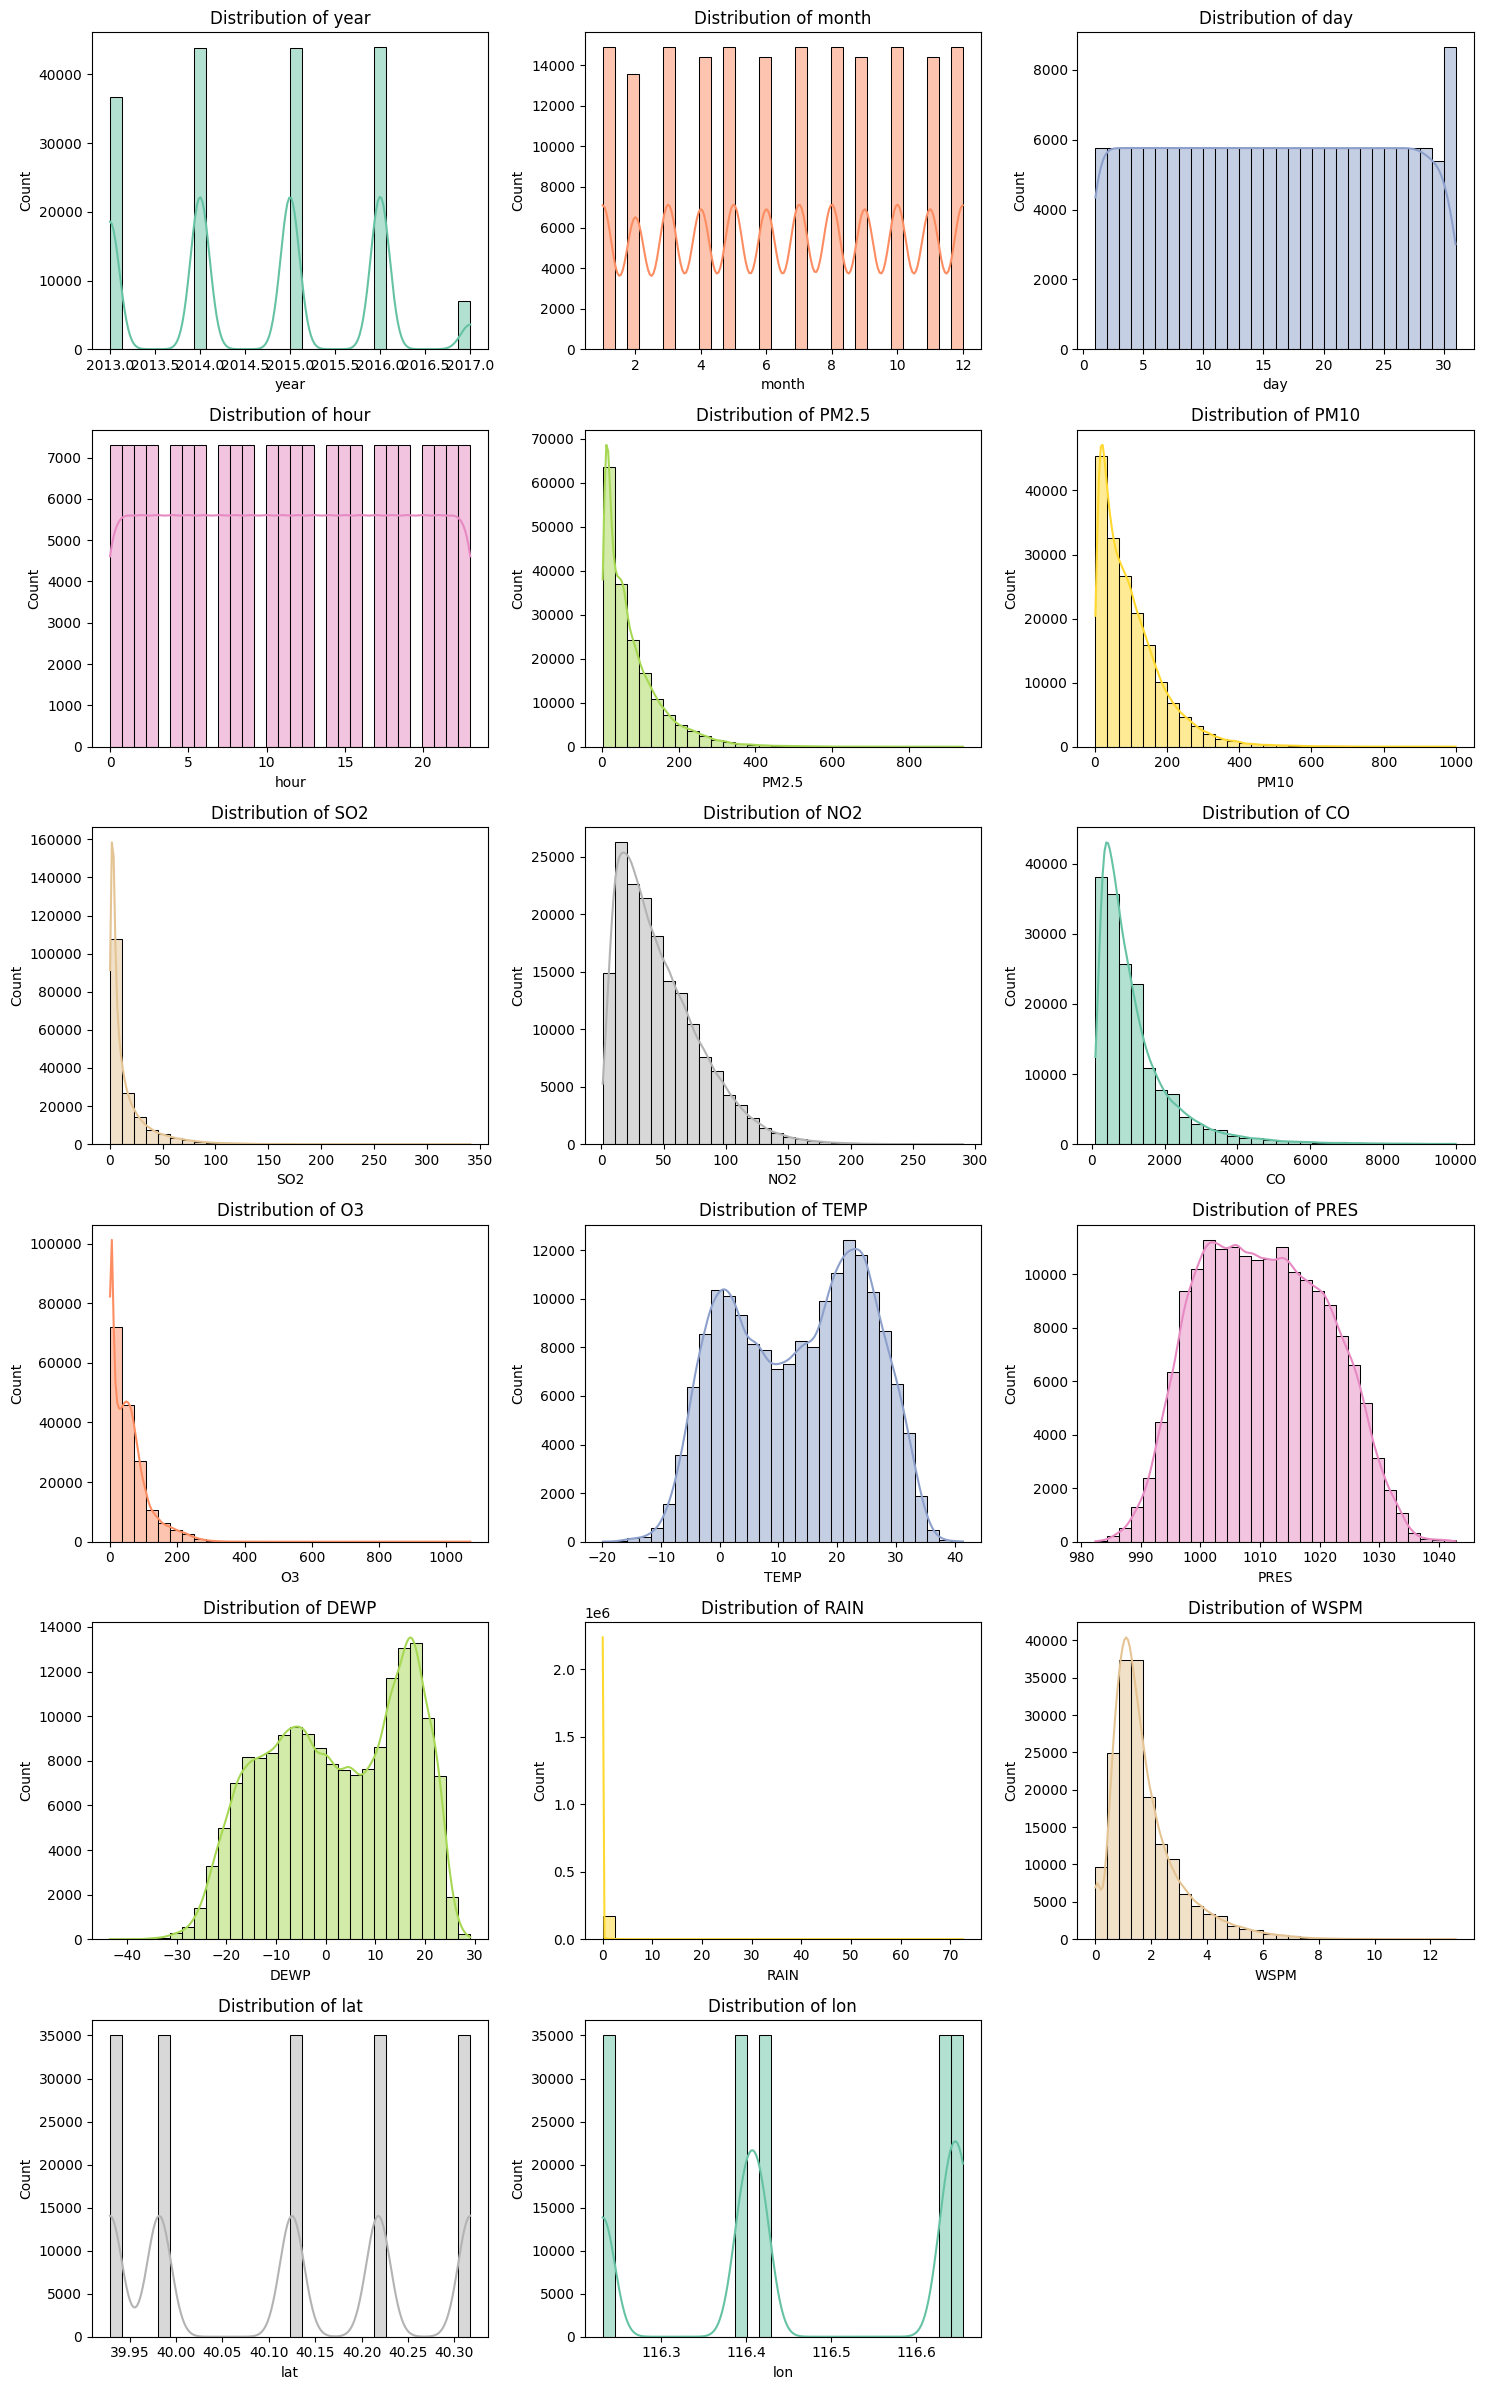

In [ ]:
numerical_cols = df.select_dtypes(include=['int64', 'float64', 'bool']).columns

num_features = len(numerical_cols)
num_rows = int(np.ceil(num_features / 3))

colors = sns.color_palette('Set2', n_colors=num_features)

plt.figure(figsize=(15, num_rows * 4))
for i, (col, color) in enumerate(zip(numerical_cols, colors), 1):
    plt.subplot(num_rows, 3, i)
    sns.histplot(df[col], bins=30, kde=True, color=color)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

To visualize the distribution of air quality categories, I created a pie chart showing the percentage of each `PM2.5_category`.

I used color coding to clearly distinguish each category, and exploded the 'Medium' slice to emphasize the most frequent level. This visualization gives a quick overview of how often each air quality condition occurs in the data.



This pie chart visualizes the overall distribution of PM2.5 air quality levels across all stations and time periods.

### Key Insights:

- The largest slice, around **37.7%**, represents the **‘Good’ air quality** category. This is a positive indicator, showing that over one-third of the observations have safe PM2.5 levels.
  
- **‘Moderate’ levels account for ~25.2%**, meaning that while the air may be acceptable, it still poses some health risks, especially for sensitive individuals.

- **Higher-risk categories ('Unhealthy for Sensitive', 'Unhealthy', and 'Very Unhealthy')** together make up **over one-third** of the data. This suggests that serious pollution events are not rare.

- Particularly, **14.3% of cases are ‘Very Unhealthy’**, and **8.1% are outright ‘Unhealthy’**, which is concerning from a public health perspective.

### Conclusion:

Although a good portion of the data shows safe air quality, the presence of high-risk pollution events in over 35% of observations indicates that **air quality remains a serious and inconsistent challenge across Beijing**. This chart complements the regional analysis by showing that pollution is not only about where — but also how often and how severely it spikes.


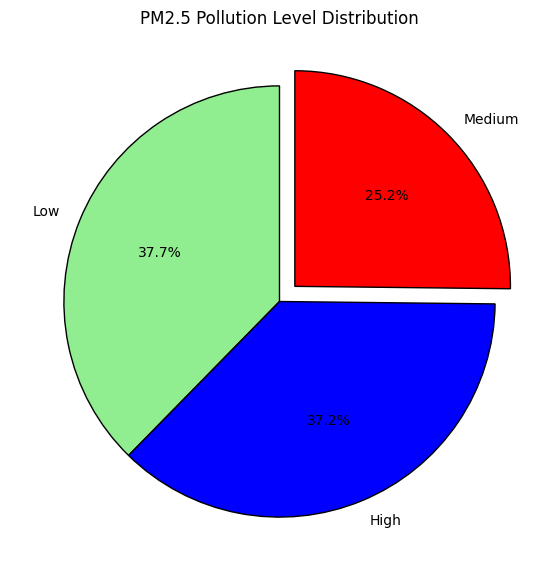

In [ ]:
weather = df['PM2.5_category'].value_counts()
labels = weather.index.tolist()

color_map = {'Low': 'lightgreen', 'Medium': 'red', 'High': 'blue'}
colors = [color_map[label] for label in labels]


plt.figure(figsize=(7, 7))
plt.pie(weather, labels=labels, autopct='%1.1f%%', colors=colors,
        explode=[0.1 if label == 'Medium' else 0 for label in labels],
        startangle=90, wedgeprops={'edgecolor': 'black'})

plt.title('PM2.5 Pollution Level Distribution')
plt.show()



This bar chart  visualizes the distribution of PM2.5 pollution levels across different area types: Industrial, Suburban, Urban, Rural, and Semi-Rural. Each bar represents the number of hourly observations that fall into one of the PM2.5 severity categories: Good, Moderate, Unhealthy for Sensitive, Unhealthy, and Very Unhealthy.

### Key Observations:

1. **Suburban and Rural areas have the most 'Good' air quality readings**, suggesting these regions generally experience cleaner air compared to others. This might be due to lower traffic, fewer factories, and more green space.

2. **Industrial and Urban areas still have a high number of 'Good' readings**, but they also show a **larger number of 'Very Unhealthy' and 'Unhealthy' cases** than Suburban and Rural zones. This implies that when pollution spikes in these zones, it tends to be more severe.

3. **The 'Unhealthy for Sensitive' category appears fairly consistent across all area types**, indicating that mid-level pollution exposure is common throughout the city — even in cleaner or greener zones.

4. **Semi-Rural areas show a mixed profile**, with a notable number of 'Very Unhealthy' observations. This could be due to nearby construction, transportation hubs like airports (e.g., Shunyi), or seasonal wind patterns that carry pollutants into outer regions.

### Conclusion:

This plot clearly shows that **air quality disadvantages exist depending on geography**, with **industrial and urban zones more prone to extreme pollution levels**, while **rural and suburban areas experience better average air quality**. However, no area is completely safe — even rural zones show significant pollution events.

These insights strengthen the need for targeted pollution control strategies based on regional characteristics.


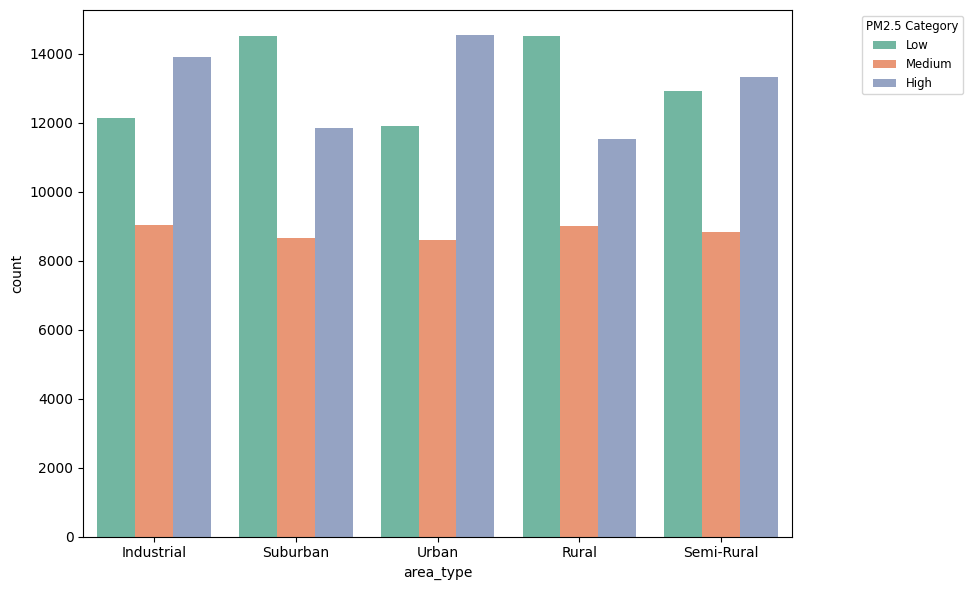

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='area_type', hue='PM2.5_category', palette='Set2')

plt.legend(title='PM2.5 Category', fontsize='small', title_fontsize='small',
        loc='upper right', bbox_to_anchor=(1.25, 1))

plt.tight_layout()
plt.show()

In [ ]:
df.head(3)

year  month  day  hour  PM2.5  PM10  SO2   NO2     CO    O3  ...  DEWP  \
0  2013      3    1     0    4.0   4.0  4.0   7.0  300.0  77.0  ... -18.8   
1  2013      3    1     1    8.0   8.0  4.0   7.0  300.0  77.0  ... -18.2   
2  2013      3    1     2    7.0   7.0  5.0  10.0  300.0  73.0  ... -18.2   

   RAIN   wd  WSPM       station   area_type     lat      lon  PM2.5_category  \
0   0.0  NNW   4.4  Aotizhongxin  Industrial  39.982  116.397             Low   
1   0.0    N   4.7  Aotizhongxin  Industrial  39.982  116.397             Low   
2   0.0  NNW   5.6  Aotizhongxin  Industrial  39.982  116.397             Low   

        date  
0 2013-03-01  
1 2013-03-01  
2 2013-03-01  

[3 rows x 22 columns]

### Geographical Disadvantage EDA

This section focuses on analyzing how air pollution levels vary depending on the geographical classification of each monitoring station — specifically, whether it's located in an Urban, Suburban, Rural, Industrial, or Semi-Rural area.

#### Boxplot of PM2.5 by Area Type
The boxplot shows the distribution and spread of PM2.5 values in each region. It helps reveal which area types consistently experience higher pollution or larger fluctuations.

#### PM2.5 Category Count by Area Type
This count plot illustrates how often each pollution severity level occurs in different area types. It highlights whether certain regions are disproportionately exposed to unhealthy air.

#### Bar Plot of Average PM2.5 and PM10
By computing and plotting the mean PM2.5 and PM10 values, we can compare the overall pollution burden each area type experiences on average.

These visualizations clearly show that geographical location significantly impacts air quality — with **industrial and urban areas generally facing worse conditions**, while **rural and suburban zones tend to experience better air quality**. However, even rural areas occasionally show high spikes, likely due to seasonal or wind-based factors.


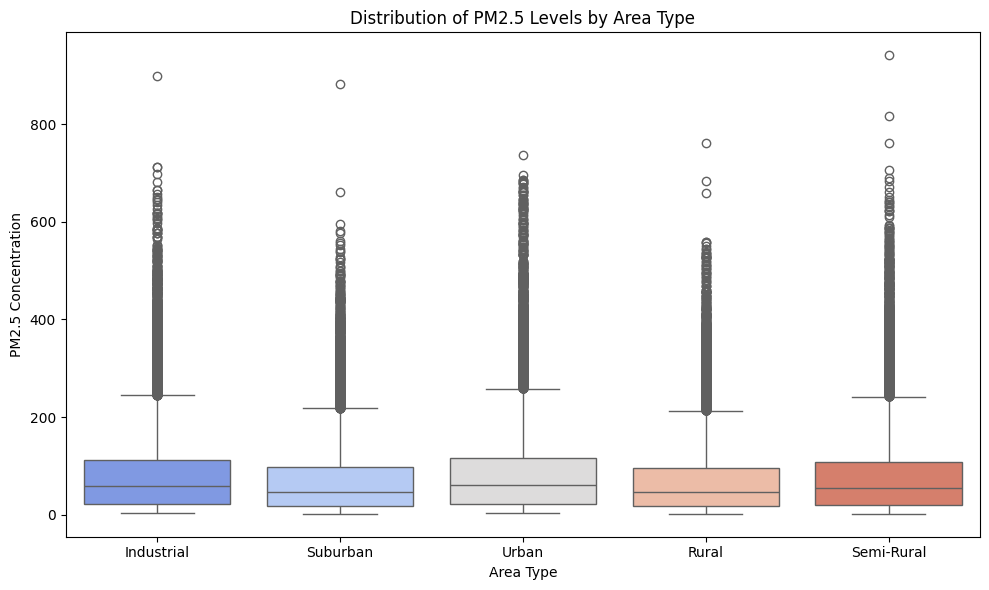

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='area_type', y='PM2.5', palette='coolwarm')
plt.title('Distribution of PM2.5 Levels by Area Type')
plt.xlabel('Area Type')
plt.ylabel('PM2.5 Concentration')
plt.tight_layout()
plt.show()


This boxplot shows the distribution of PM2.5 concentrations for each area type: Industrial, Suburban, Urban, Rural, and Semi-Rural.

#### Key Observations:

1. **All areas have significant outliers**, with PM2.5 values shooting well above 500 µg/m³. This indicates that high pollution spikes are possible everywhere — but their frequency and central tendency differ.

2. **Urban and Industrial zones have higher median values** compared to Suburban and Rural areas. This suggests that pollution levels in the city center and industrial hubs tend to be consistently higher.

3. **Semi-Rural areas have a surprisingly wide spread**, with a large number of values near the higher end. This may be influenced by nearby infrastructure like airports or highways (e.g., Shunyi).

4. **Rural and Suburban zones have lower median values and slightly tighter interquartile ranges (IQRs)**, indicating more stable and cleaner air most of the time.

#### Conclusion:

While pollution is a city-wide issue, this plot shows a clear geographical disadvantage for **Urban and Industrial areas**, where residents are more consistently exposed to higher PM2.5 levels. It also reveals that **Rural and Suburban zones are not immune**, as high outliers appear even there — possibly due to wind patterns, seasonal events, or external sources drifting in.


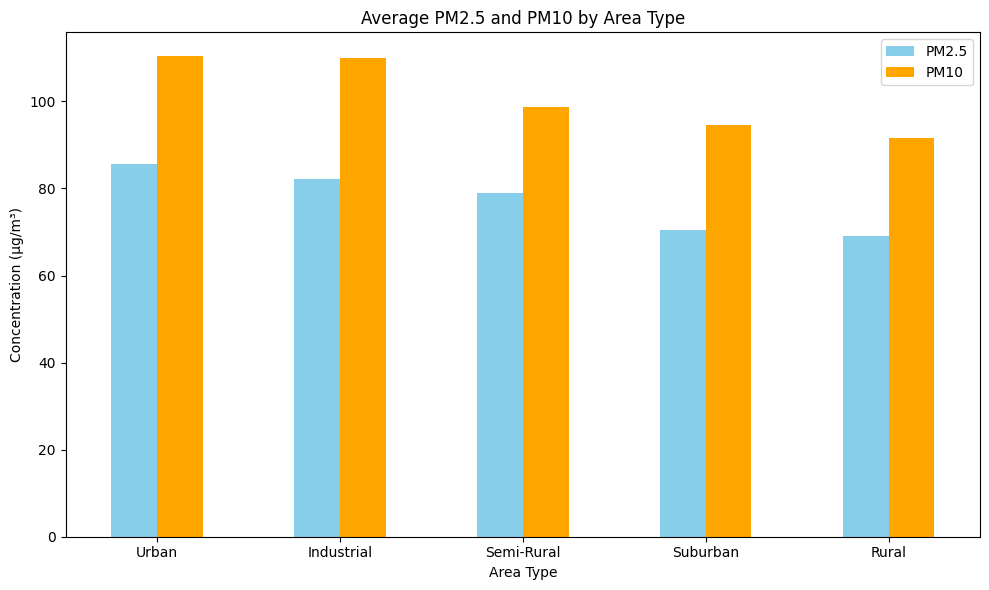

In [ ]:
pollution_means = df.groupby('area_type')[['PM2.5', 'PM10']].mean().sort_values(by='PM2.5', ascending=False)

pollution_means.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'])
plt.title('Average PM2.5 and PM10 by Area Type')
plt.ylabel('Concentration (µg/m³)')
plt.xlabel('Area Type')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# Map months to seasons (Northern Hemisphere logic)
season_map = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
}

df['season'] = df['month'].map(season_map)

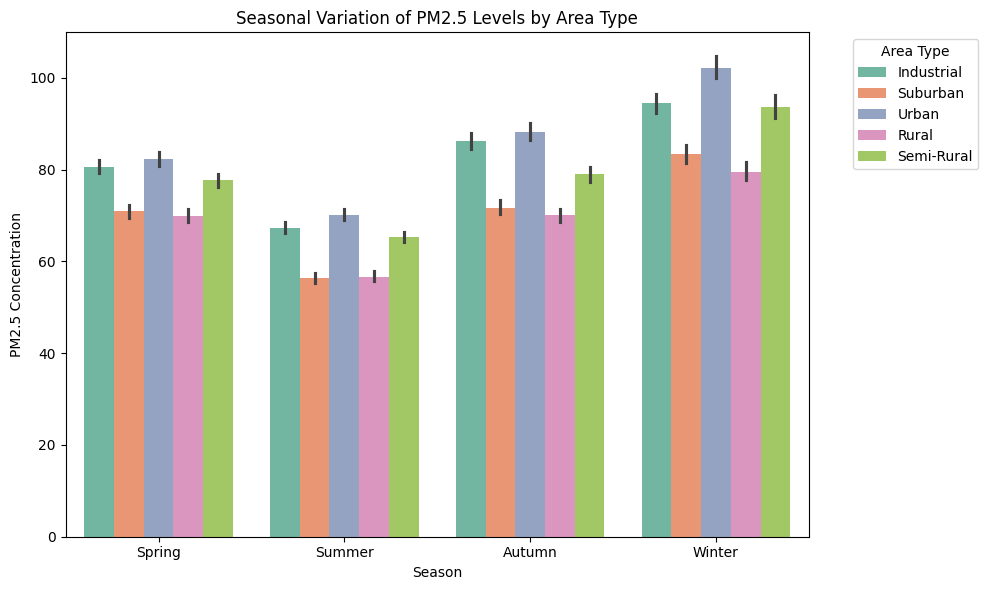

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='season', y='PM2.5', hue='area_type', palette='Set2')
plt.title('Seasonal Variation of PM2.5 Levels by Area Type')
plt.xlabel('Season')
plt.ylabel('PM2.5 Concentration')
plt.legend(title='Area Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Monthly Trends of Key Pollutants: SO2, NO2, CO, and O3

The plot displays the monthly median levels of four significant pollutants: SO2, NO2, CO, and O3, providing a comprehensive overview of their seasonal patterns.

#### Observations:

- **SO2:** Elevated concentrations are observed in the winter months, notably in **January, February, and December**, suggesting increased emissions from heating and lower atmospheric dispersion (Wang et al., 2014).
- **NO2:** Peaks during **January, February, and the late fall months (October to December)**, which may be attributed to heightened vehicular emissions and domestic heating during the colder months (Zheng et al., 2018).
- **CO:** Similarly, CO levels are higher in **January, February, and December**, indicating a correlation with fossil fuel burning for heating and potential traffic emissions (Li et al., 2017).
- **O3:** In contrast to SO2, NO2, and CO, O3 levels reach their maximum in the warmer months, particularly **April to July**, due to increased photochemical reactions under higher sunlight (Li et al., 2017).

#### Conclusion:

The analysis underscores that while SO2, NO2, and CO show higher concentrations in colder months, influenced by anthropogenic activities, O3 demonstrates a distinct pattern peaking in warmer months due to natural atmospheric processes (Wang et al., 2014). These findings highlight that **pollutant levels are uniquely impacted by seasonal and meteorological factors**, necessitating distinct mitigation strategies for each pollutant and season.

### References

- Wang, Y. et al. (2014) ‘Spatial and temporal variations of six criteria air pollutants in 31 provincial capital cities in China during 2013–2014’, Environment International, 73, pp. 413–422. Available at: https://doi.org/10.1016/j.envint.2014.08.016.

- Zheng, B. et al. (2018) ‘Trends in China’s anthropogenic emissions since 2010 as the consequence of clean air actions’, Atmospheric Chemistry and Physics, 18(19), pp. 14095–14111. Available at: https://doi.org/10.5194/acp-18-14095-2018.

- Li, K. et al. (2017) ‘Meteorological and chemical impacts on ozone formation: A case study in Hangzhou, China’, Atmospheric Research, 196, pp. 40–52. Available at: https://doi.org/10.1016/j.atmosres.2017.06.003.

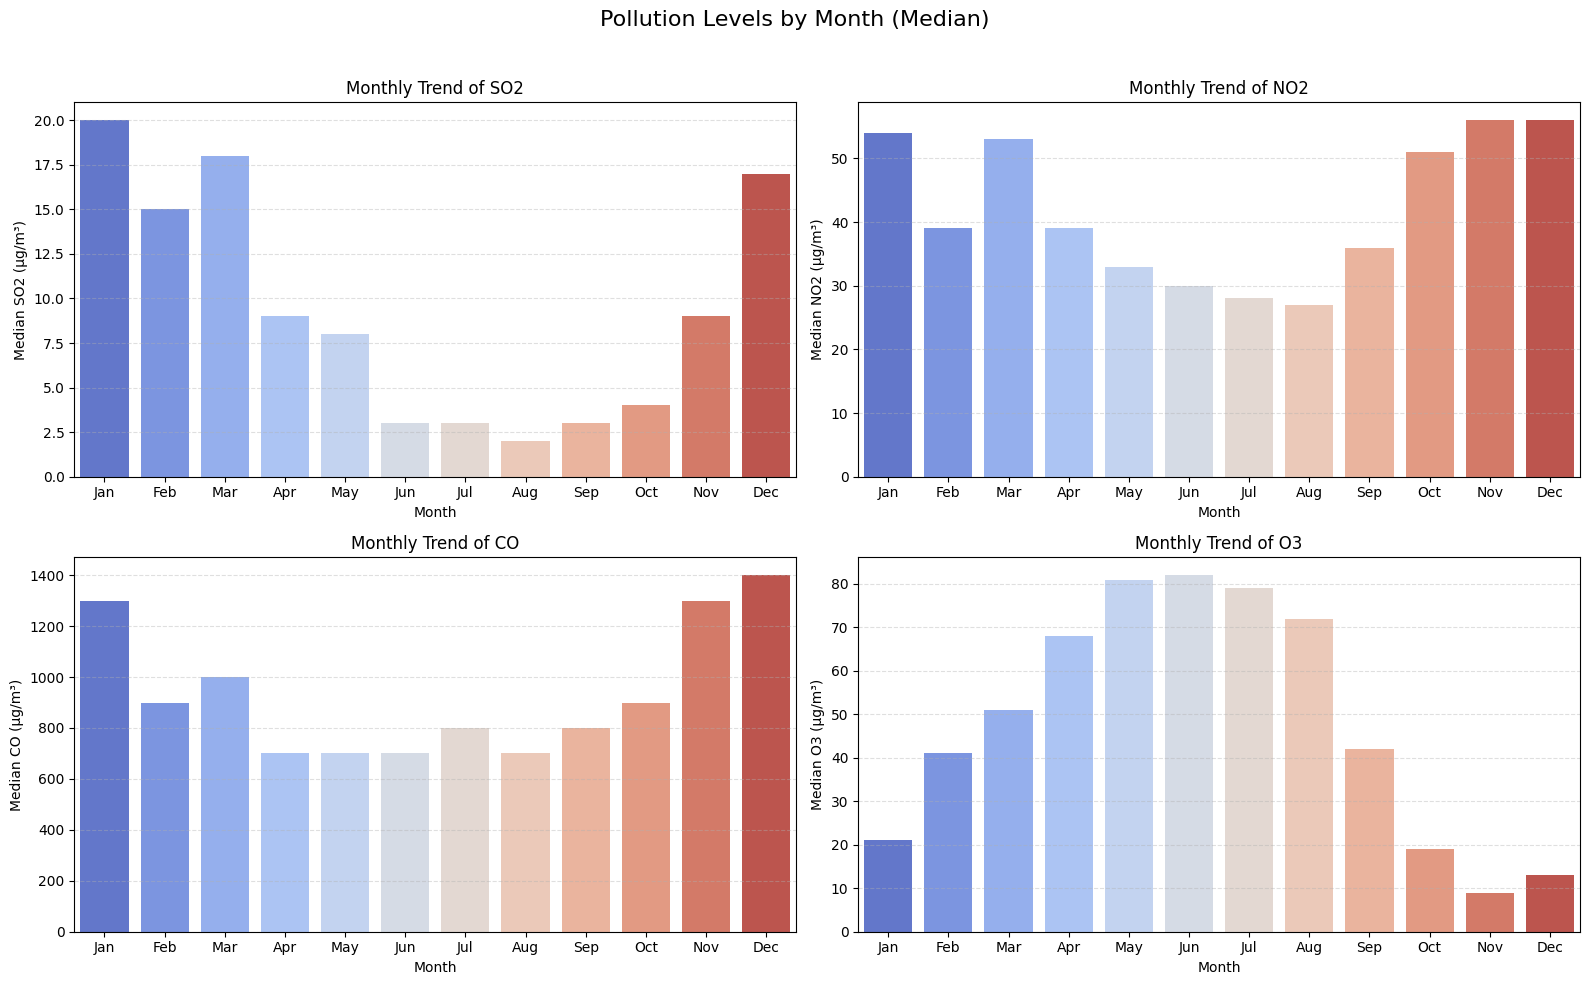

In [ ]:
plt.figure(figsize=(16, 10))
pollutants = ['SO2', 'NO2', 'CO', 'O3']
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i, col in enumerate(pollutants, 1):
    ax = plt.subplot(2, 2, i)
    sns.barplot(x='month', y=col, data=df, palette='coolwarm',
                estimator=np.median, ci=None, ax=ax)
    ax.set_title(f'Monthly Trend of {col}')
    ax.set_xlabel('Month')
    ax.set_ylabel(f'Median {col} (µg/m³)')
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    ax.set_xticks(range(12))
    ax.set_xticklabels(month_labels)

plt.suptitle('Pollution Levels by Month (Median)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
df.columns

Index(['year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO',
       'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station',
       'area_type', 'lat', 'lon', 'PM2.5_category', 'date', 'season'],
      dtype='object')

### Feature Engineering

To extract more meaning from the raw dataset and help our model better understand air pollution patterns, I engineered several new features based on scientific reasoning and environmental knowledge:

1. **temp_dewp_diff**: The difference between temperature and dew point, which indicates humidity. A smaller gap suggests more atmospheric moisture, leading to more suspended particulate matter.

2. **inverse_wind**: Since strong winds disperse pollution, this feature emphasizes stagnant air conditions where pollution builds up. It is calculated as the inverse of wind speed.

3. **night_time**: A binary flag marking late-night hours (before 6 AM or after 9 PM). These hours often have less traffic but more pollution retention due to stable atmospheric layers.

4. **Rain_Flag**: Indicates whether it was raining or not. Rain can help clean the air, reducing PM2.5 and PM10 by washing particles out of the atmosphere.

5. **CO_NO2_ratio**: This ratio reflects traffic-related pollution. CO is generally from incomplete combustion, while NO2 spikes in high-traffic zones.

By transforming the raw environmental readings into meaningful indicators, this feature engineering step enhances the model's ability to detect patterns, especially those tied to **geographical disadvantage**, **weather effects**, and **daily human activity**.


In [ ]:
# 1. Temperature and Dew Point Difference – signals humidity
df['temp_dewp_diff'] = df['TEMP'] - df['DEWP']

# 2. Inverse Wind Speed – high value means still air, likely to trap pollutants
df['inverse_wind'] = 1 / (df['WSPM'] + 0.1)  # avoid division by zero

# 3. Night Time Indicator – pollution might settle at night due to low wind + no sun
df['night_time'] = df['hour'].apply(lambda x: 1 if x < 6 or x >= 21 else 0)

# 4. Rain Flag – rain helps clean the air, may lower PM2.5
df['Rain_Flag'] = df['RAIN'].apply(lambda x: 1 if x > 0 else 0)

df['CO_NO2_ratio'] = df['CO'] / (df['NO2'] + 0.1)

# Optional: drop columns already encoded or transformed
df.drop(['TEMP', 'DEWP', 'WSPM', 'RAIN', 'hour', 'PM2.5'], axis=1, inplace=True)

In [ ]:
df.head(1).T

0
year                           2013
month                             3
day                               1
PM10                            4.0
SO2                             4.0
NO2                             7.0
CO                            300.0
O3                             77.0
PRES                         1023.0
wd                              NNW
station                Aotizhongxin
area_type                Industrial
lat                          39.982
lon                         116.397
PM2.5_category                  Low
date            2013-03-01 00:00:00
season                       Spring
temp_dewp_diff                 18.1
inverse_wind               0.222222
night_time                        1
Rain_Flag                         0
CO_NO2_ratio              42.253521

### Data Preprocessing: Handling Missing Values

To prepare the dataset for modeling, I checked for missing values in both numerical and categorical columns.

- For numeric features like `PM10`, `SO2`, `NO2`, etc., I used the **median** to fill missing values. Median imputation is robust to outliers and helps maintain the distribution of the data.
- For the wind direction (`wd`), which is categorical, I used the **mode**, i.e., the most frequently occurring wind direction.

After imputation, I rechecked for missing values and confirmed that the dataset is now clean and ready for further analysis or modeling.


In [ ]:
df.isnull().sum()

year                  0
month                 0
day                   0
PM10               3178
SO2                4502
NO2                6295
CO                10094
O3                 5627
PRES                194
wd                 1084
station               0
area_type             0
lat                   0
lon                   0
PM2.5_category        0
date                  0
season                0
temp_dewp_diff      200
inverse_wind        164
night_time            0
Rain_Flag             0
CO_NO2_ratio      13353
dtype: int64

In [ ]:
for label,content in df.items():
  if pd.api.types.is_numeric_dtype(content):
    if pd.isnull(content).sum():
      print(label)

PM10
SO2
NO2
CO
O3
PRES
temp_dewp_diff
inverse_wind
CO_NO2_ratio


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175320 entries, 0 to 175319
Data columns (total 22 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   year            175320 non-null  int64         
 1   month           175320 non-null  int64         
 2   day             175320 non-null  int64         
 3   PM10            172142 non-null  float64       
 4   SO2             170818 non-null  float64       
 5   NO2             169025 non-null  float64       
 6   CO              165226 non-null  float64       
 7   O3              169693 non-null  float64       
 8   PRES            175126 non-null  float64       
 9   wd              174236 non-null  object        
 10  station         175320 non-null  object        
 11  area_type       175320 non-null  object        
 12  lat             175320 non-null  float64       
 13  lon             175320 non-null  float64       
 14  PM2.5_category  175320 non-null  obj

# **Treating Missing Values**

In [ ]:
df['PM10'].fillna(df['SO2'].median(), inplace=True)
df['SO2'].fillna(df['SO2'].median(),inplace=True)
df['NO2'].fillna(df['NO2'].median(), inplace=True)
df['CO'].fillna(df['CO'].median(), inplace=True)
df['O3'].fillna(df['O3'].median(), inplace=True)
df['PRES'].fillna(df['PRES'].median(), inplace=True)
df['temp_dewp_diff'].fillna(df['temp_dewp_diff'].median(), inplace=True)
df['inverse_wind'].fillna(df['inverse_wind'].median(), inplace=True)

df['wd'].fillna(df['wd'].mode()[0],inplace=True)

In [ ]:
df.isnull().sum()

year                  0
month                 0
day                   0
PM10                  0
SO2                   0
NO2                   0
CO                    0
O3                    0
PRES                  0
wd                    0
station               0
area_type             0
lat                   0
lon                   0
PM2.5_category        0
date                  0
season                0
temp_dewp_diff        0
inverse_wind          0
night_time            0
Rain_Flag             0
CO_NO2_ratio      13353
dtype: int64

### 🔄 Target Encoding & Data Cleaning

To prepare for modeling, I performed the following preprocessing steps:

#### 🎯 1. Target Encoding
The PM2.5 pollution categories (e.g., Good, Moderate, Unhealthy) were encoded into numerical labels (0–4) using `LabelEncoder`. This is required for classification models to work with categorical targets.

#### ✂️ 2. Dropping Redundant Columns
The `year` and `day` columns were removed, as they do not contribute much to the model once we’ve already included season and month.

#### 🔍 3. Duplicate Check
I checked for and counted duplicate rows based on all major input features. While no duplicates were removed at this stage, this check helps validate the uniqueness of records.









In [ ]:
le = LabelEncoder()
df['PM2.5_category_encoded'] = le.fit_transform(df['PM2.5_category'])
#target = 'PM2.5_category_encoded'
df.drop(columns=['PM2.5_category'],inplace=True)

In [ ]:
df['PM2.5_category_encoded'].value_counts()

PM2.5_category_encoded
1    66020
0    65158
2    44142
Name: count, dtype: int64

In [ ]:
df.head(1)

year  month  day  PM10  SO2  NO2     CO    O3    PRES   wd  ...     lat  \
0  2013      3    1   4.0  4.0  7.0  300.0  77.0  1023.0  NNW  ...  39.982   

       lon       date  season temp_dewp_diff inverse_wind  night_time  \
0  116.397 2013-03-01  Spring           18.1     0.222222           1   

   Rain_Flag  CO_NO2_ratio  PM2.5_category_encoded  
0          0     42.253521                       1  

[1 rows x 22 columns]

## Dropping columns to avoid unnecessary complexity based on feature importance

In [ ]:
df.drop(columns=['year', 'day','area_type','lat','lon','date','season'], inplace=True)

# Checking for Duplicated rows

In [ ]:
duplicate_count = df.duplicated(subset=['PM10','SO2','NO2','CO','O3','PRES','station','wd','temp_dewp_diff','inverse_wind','night_time'],).sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


# Splitting data apply transformation such as Encoding and Log Transformation

In [ ]:
X = df.drop('PM2.5_category_encoded', axis=1)
y = df['PM2.5_category_encoded']

In [ ]:
np.random.seed(42)

# Stratified Sampling (60,000 samples)
X_sampled, _, y_sampled, _ = train_test_split(
    X, y,
    train_size=60000,
    stratify=y,
    random_state=42
)

# Train-test split from sampled data (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled,
    test_size=0.2,
    stratify=y_sampled,
    random_state=42
)

print(f"Sampled X shape: {X_sampled.shape}")
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")
print(f"Train class distribution:\n{y_train.value_counts()}")

Sampled X shape: (60000, 14)
Train size: (48000, 14), Test size: (12000, 14)
Train class distribution:
PM2.5_category_encoded
1    18075
0    17839
2    12086
Name: count, dtype: int64


# Log Normal Transformation for Data Skew

In [ ]:
log_vars = ['PM10', 'CO', 'O3', 'SO2', 'NO2', 'PRES', 'temp_dewp_diff', 'inverse_wind']

for col in log_vars:
    X_train[col + "_log"] = np.log1p(X_train[col])
    X_test[col + "_log"] = np.log1p(X_test[col])

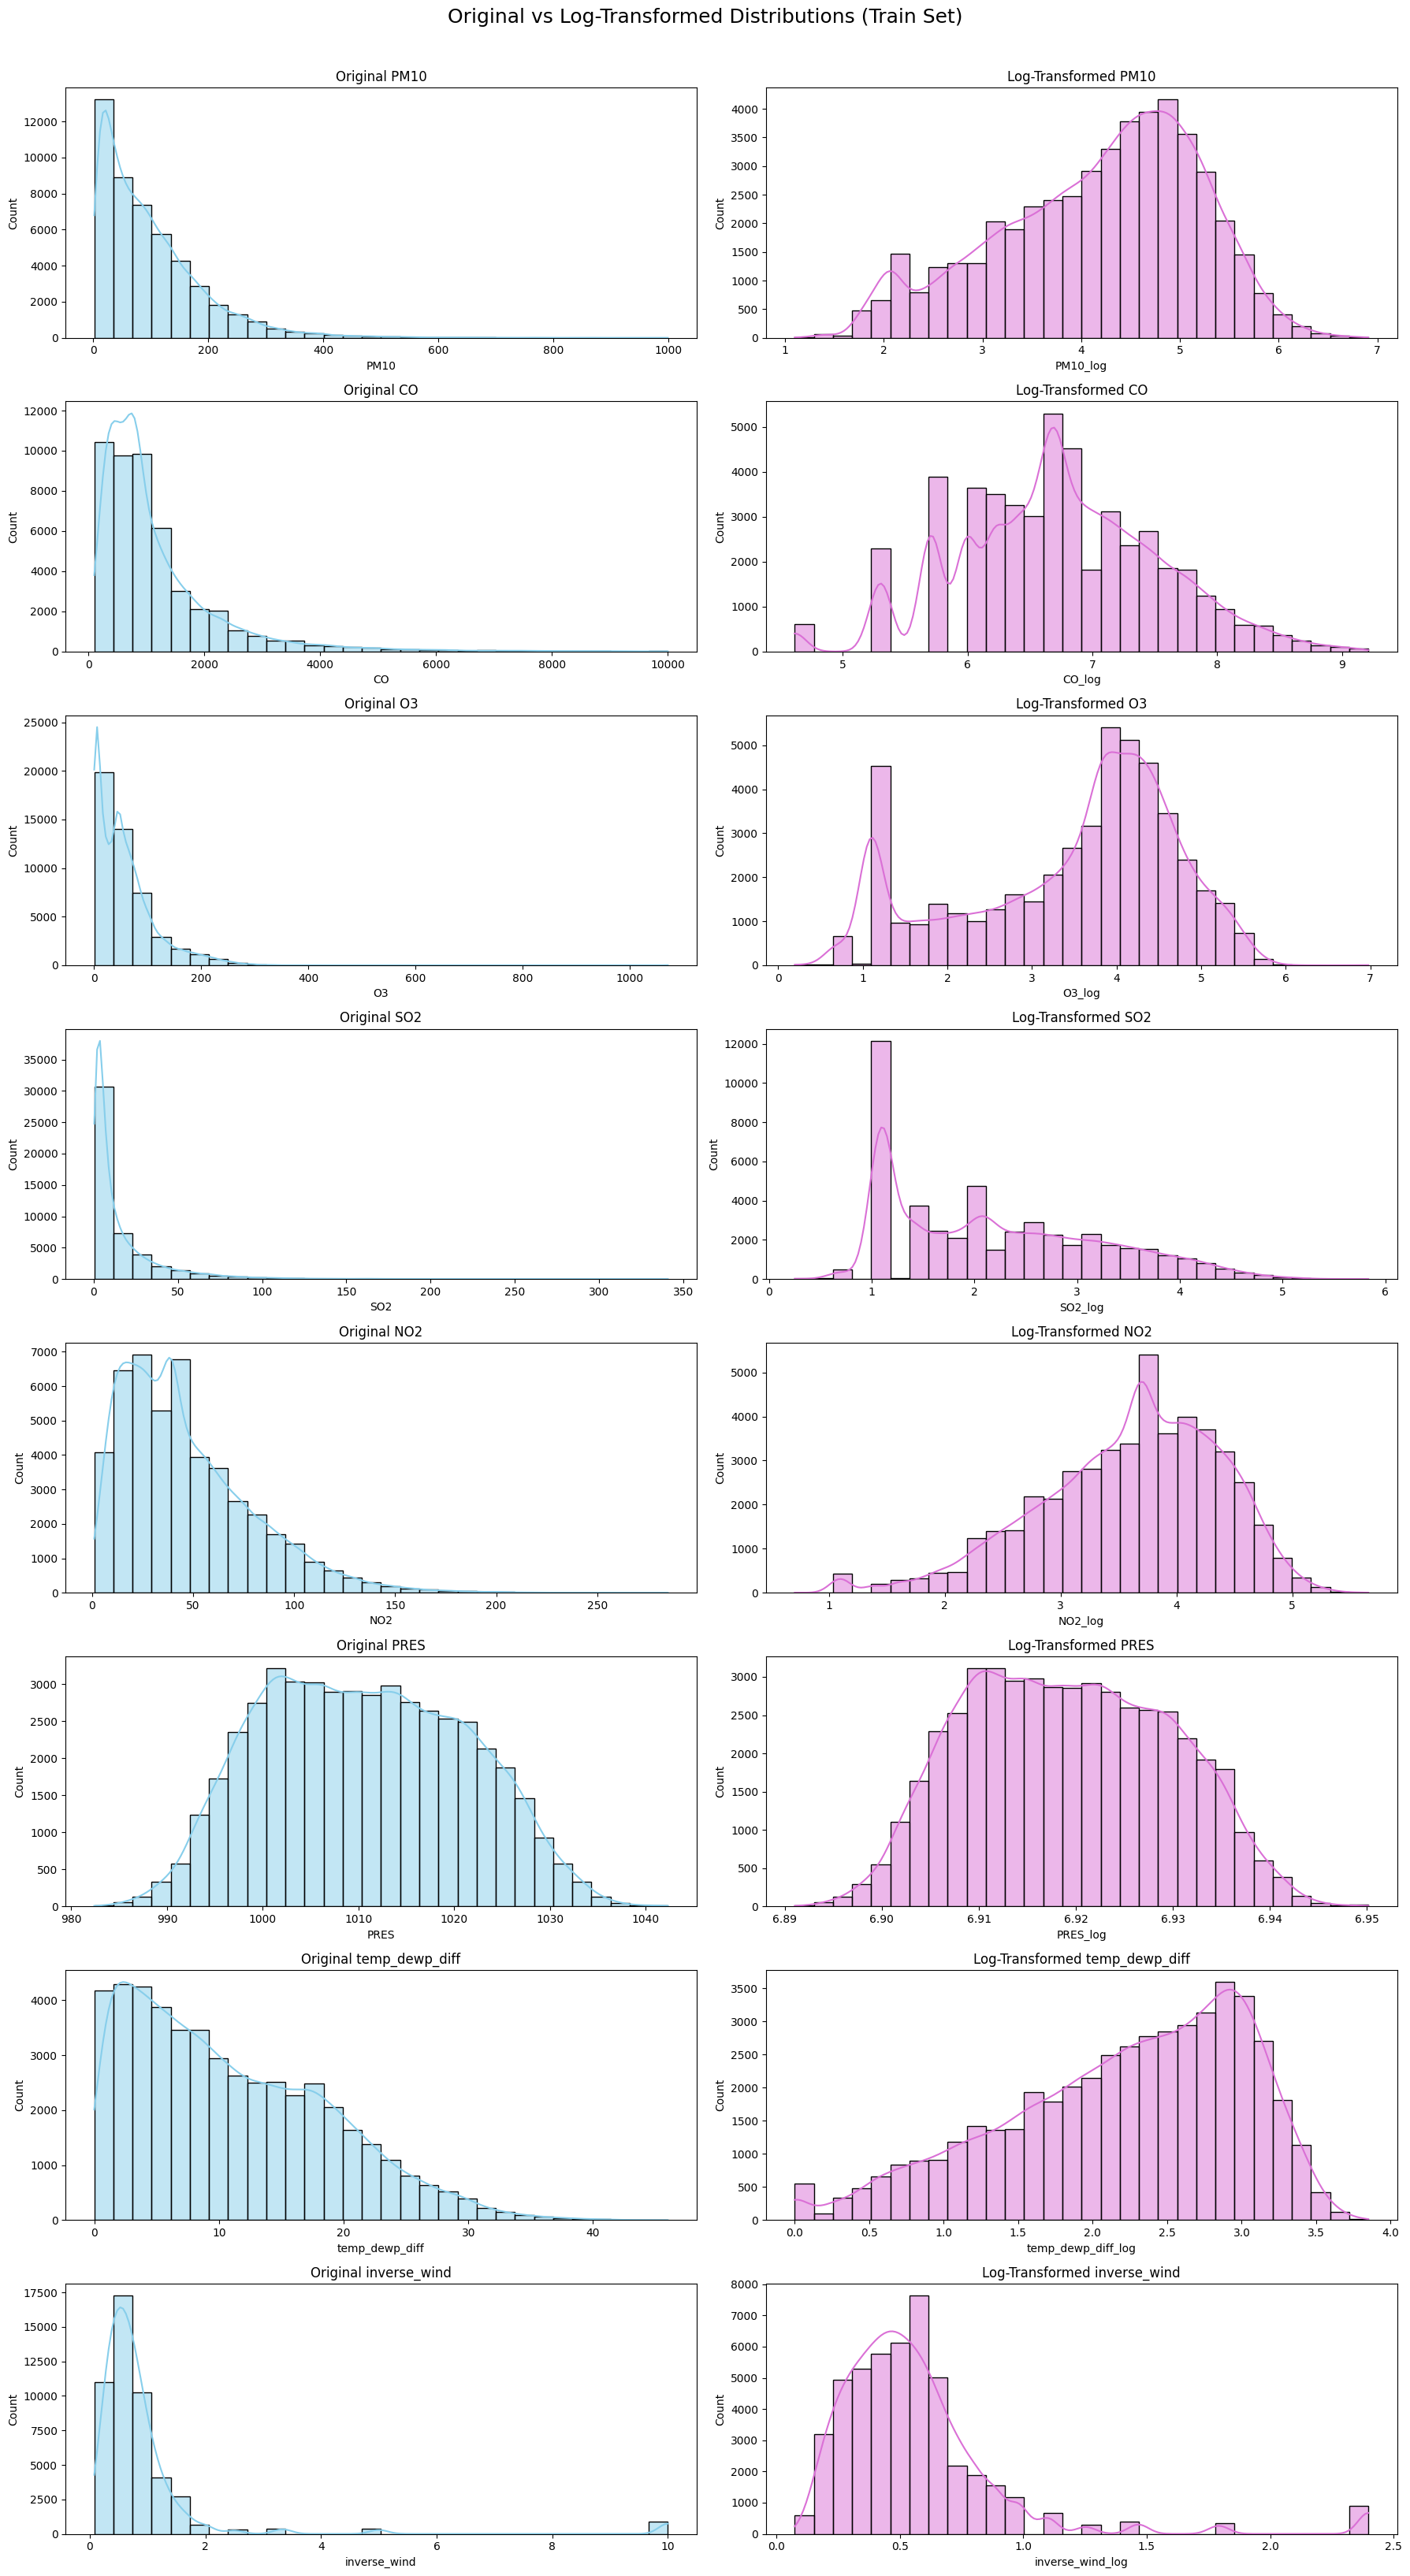

In [ ]:
log_vars = ['PM10', 'CO', 'O3', 'SO2', 'NO2', 'PRES', 'temp_dewp_diff', 'inverse_wind']
num_vars = len(log_vars)

plt.figure(figsize=(18, num_vars * 4))

for i, var in enumerate(log_vars):
    # Original distribution
    plt.subplot(num_vars, 2, 2*i + 1)
    sns.histplot(X_train[var], bins=30, kde=True, color='skyblue')
    plt.title(f'Original {var}', fontsize=12)

    # Log-transformed distribution
    plt.subplot(num_vars, 2, 2*i + 2)
    sns.histplot(X_train[f'{var}_log'], bins=30, kde=True, color='orchid')
    plt.title(f'Log-Transformed {var}', fontsize=12)

plt.tight_layout()
plt.suptitle("Original vs Log-Transformed Distributions (Train Set)", fontsize=18, y=1.02)
plt.show()

In [ ]:
X_train.drop(columns=log_vars, inplace=True)
X_test.drop(columns=log_vars, inplace=True)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48000 entries, 141860 to 170936
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   month               48000 non-null  int64  
 1   wd                  48000 non-null  object 
 2   station             48000 non-null  object 
 3   night_time          48000 non-null  int64  
 4   Rain_Flag           48000 non-null  int64  
 5   CO_NO2_ratio        44355 non-null  float64
 6   PM10_log            48000 non-null  float64
 7   CO_log              48000 non-null  float64
 8   O3_log              48000 non-null  float64
 9   SO2_log             48000 non-null  float64
 10  NO2_log             48000 non-null  float64
 11  PRES_log            48000 non-null  float64
 12  temp_dewp_diff_log  48000 non-null  float64
 13  inverse_wind_log    48000 non-null  float64
dtypes: float64(9), int64(3), object(2)
memory usage: 5.5+ MB


# Feature Encoding

In [ ]:
categorical_features = ['station', 'wd']

ohe_pipeline = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

X_train_encoded_array = ohe_pipeline.fit_transform(X_train)
X_test_encoded_array = ohe_pipeline.transform(X_test)

In [ ]:
# Add this to retain feature names and convert back to DataFrame
ohe_feature_names = ohe_pipeline.named_transformers_['cat'].get_feature_names_out(categorical_features)
remainder_features = [col for col in X_train.columns if col not in categorical_features]
final_feature_names = list(ohe_feature_names) + remainder_features

# Convert the encoded variable to dataframe
X_train_encoded = pd.DataFrame(X_train_encoded_array, columns=final_feature_names, index=X_train.index)
X_test_encoded = pd.DataFrame(X_test_encoded_array, columns=final_feature_names, index=X_test.index)

# Check for Multicollinarity using Heatmap

We did multicollinarity and found that Co_log is 0.71 is moderately to highl;y collatered with NO2_log but since we are fopcused on tree based and boosting models and multicolinarity doesn't affect these models so we mocve to the next step but if we work with KNN and all then its needed

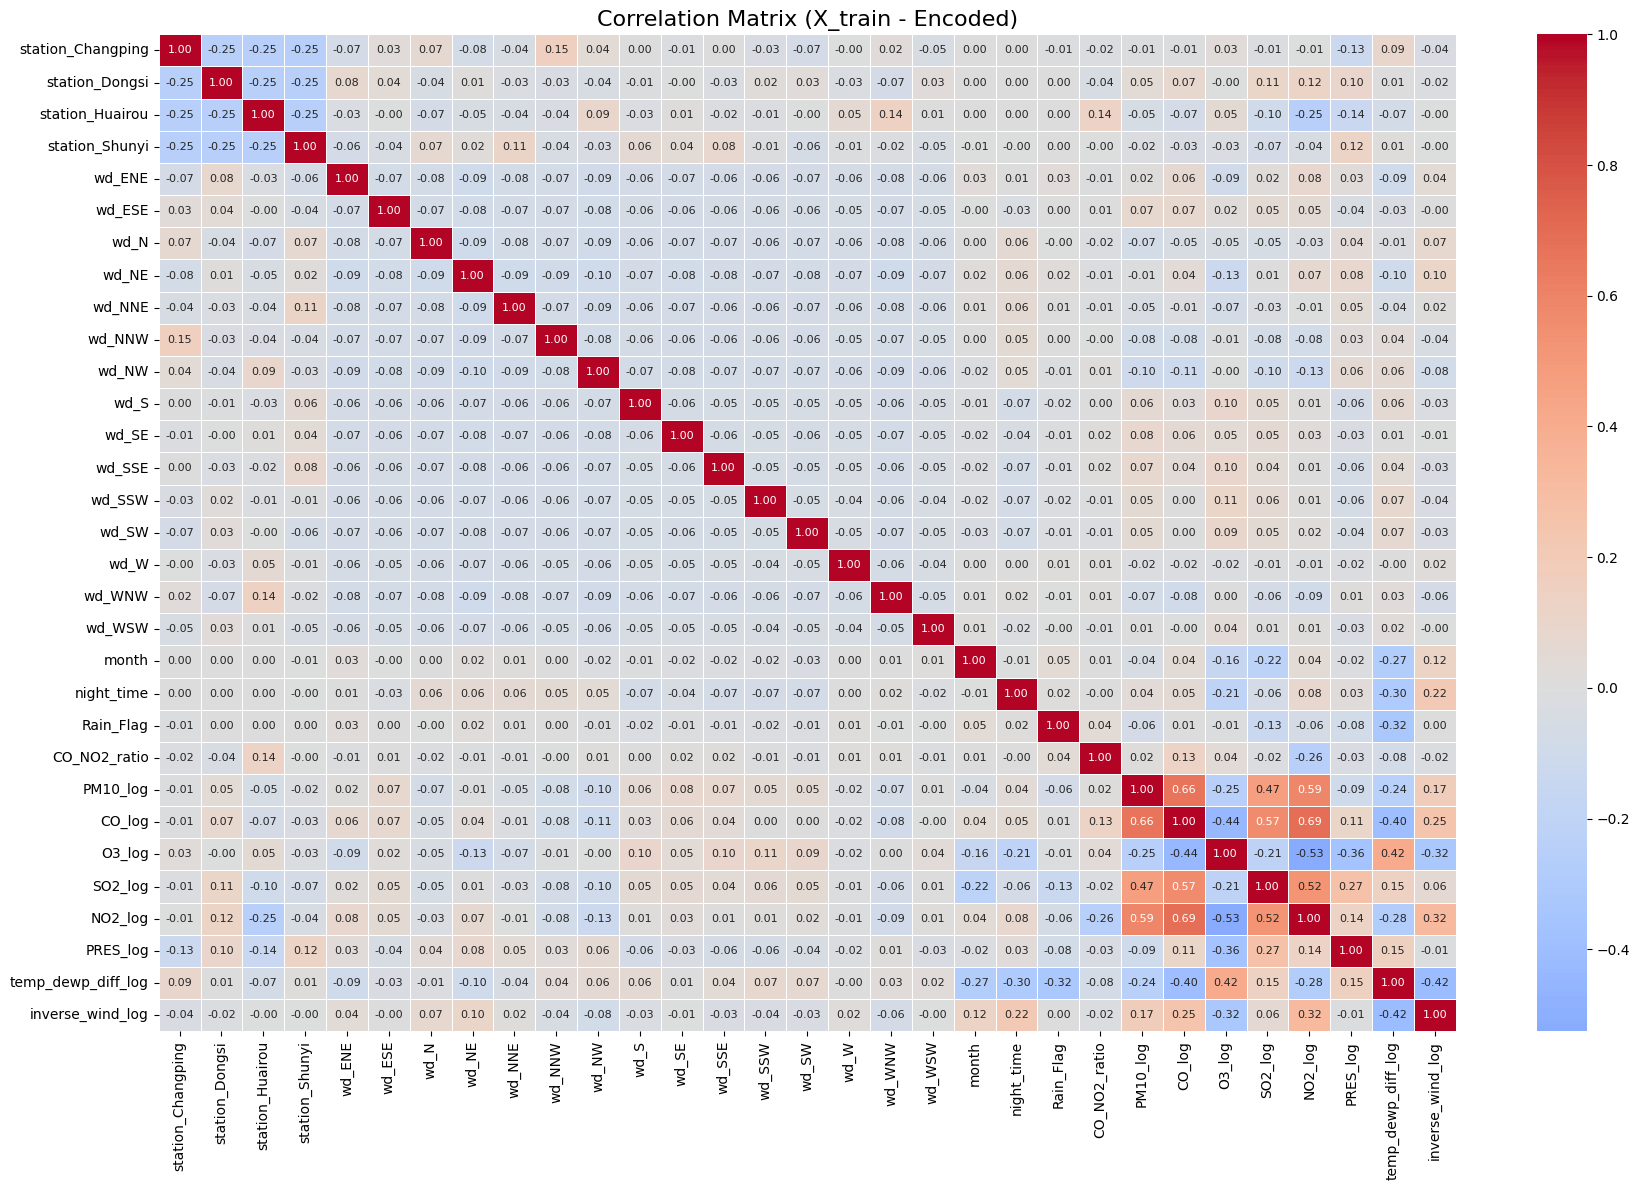

In [ ]:
plt.figure(figsize=(18, 12))
corr_matrix = X_train_encoded.corr()

sns.heatmap(corr_matrix, cmap='coolwarm', center=0, linewidths=0.5,
            annot=True, fmt=".2f", annot_kws={"size": 8})
plt.title("Correlation Matrix (X_train - Encoded)", fontsize=16)
plt.tight_layout()
plt.show()

### Split between categorical and Numeric features

In [ ]:
station_wd_features = []
for features in X_train_encoded.columns:
    if features.startswith('station_') or features.startswith('wd_'):
        station_wd_features.append(features)

numeric_features = []
for feat in X_train_encoded.columns:
    if feat not in station_wd_features:
        numeric_features.append(feat)

# Dealing with Target Imbalance

In [ ]:
X_train_encoded[numeric_features] = X_train_encoded[numeric_features].fillna(X_train_encoded[numeric_features].median())
X_test_encoded[numeric_features] = X_test_encoded[numeric_features].fillna(X_test_encoded[numeric_features].median())
smote = SMOTE(random_state=42)
X_train_numeric_smote, y_train_smote = smote.fit_resample(X_train_encoded[numeric_features], y_train)

In [ ]:
y_train_smote.value_counts()

PM2.5_category_encoded
0    18075
2    18075
1    18075
Name: count, dtype: int64

## Repeat the categorical rows to match smote for numerical values

Since SMOTE only altered the numeric features, the original categorical part is now too short

So you repeat the categorical data to match the number of oversampled rows.

In [ ]:
repeat_factor = int(X_train_numeric_smote.shape[0] / X_train_encoded.shape[0])
X_train_station_wd_repeated = pd.DataFrame(
    np.repeat(X_train_encoded[station_wd_features].values, repeat_factor, axis=0),
    columns=station_wd_features
)

## Combine them into dataframe

In [ ]:
X_train_combined = pd.concat([X_train_station_wd_repeated.reset_index(drop=True),
                              pd.DataFrame(X_train_numeric_smote, columns=numeric_features).reset_index(drop=True)],
                             axis=1)

# Feature Scaling

## Only fit the numerical features using feature scaling

In [ ]:
scaler = StandardScaler()
X_train_scaled = X_train_combined.copy()
X_train_scaled[numeric_features] = scaler.fit_transform(X_train_scaled[numeric_features])

# Prepare and scale test data
X_test_scaled = X_test_encoded[station_wd_features + numeric_features].copy()
X_test_scaled[numeric_features] = scaler.transform(X_test_scaled[numeric_features])

In [ ]:
X_train_scaled = X_train_scaled.dropna()
y_train_smote = y_train_smote[X_train_scaled.index]

# Modelling

# SMOTE baseline

In [ ]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "LightGBM": LGBMClassifier(verbose=-1),
    "CatBoost": CatBoostClassifier(verbose=0)
}

In [ ]:
def evaluate_baseline_models(models, X_train_scaled, y_train_smote, X_test_scaled, y_test):

    results = []
    trained_models = {}

    for name, model in models.items():
        print(f"\nTraining: {name}")
        model.fit(X_train_scaled, y_train)
        trained_models[name] = model

        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)

        train_acc = accuracy_score(y_train, y_pred_train)
        test_acc = accuracy_score(y_test, y_pred_test)
        precision = precision_score(y_test, y_pred_test, average='weighted')
        recall = recall_score(y_test, y_pred_test, average='weighted')
        f1 = f1_score(y_test, y_pred_test, average='weighted')

        try:
            y_proba = model.predict_proba(X_test_scaled)
            roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
        except:
            roc_auc = 'N/A'

        print(f"Test Accuracy: {test_acc:.4f}")
        print("Classification Report:\n", classification_report(y_test, y_pred_test))

        results.append({
            'Model': name,
            'Train Accuracy': train_acc,
            'Test Accuracy': test_acc,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1,
            'ROC AUC': roc_auc
        })

    results_df = pd.DataFrame(results)
    return results_df, trained_models

In [ ]:
baseline_results_df, baseline_models = evaluate_baseline_models(
    models,
    X_train_scaled,
    y_train_smote,
    X_test_scaled,
    y_test
)


Training: LogisticRegression
Test Accuracy: 0.8170
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89      4469
           1       0.87      0.86      0.86      4550
           2       0.65      0.62      0.63      2981

    accuracy                           0.82     12000
   macro avg       0.80      0.79      0.80     12000
weighted avg       0.81      0.82      0.82     12000


Training: KNN
Test Accuracy: 0.8069
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      4469
           1       0.88      0.88      0.88      4550
           2       0.64      0.57      0.61      2981

    accuracy                           0.81     12000
   macro avg       0.78      0.78      0.78     12000
weighted avg       0.80      0.81      0.80     12000


Training: Random Forest
Test Accuracy: 0.8706
Classification Report:
               precision    rec

In [ ]:
print("\nModel Comparison:")
display(baseline_results_df)


Model Comparison:


Model  Train Accuracy  Test Accuracy  Precision    Recall  \
0  LogisticRegression        0.820167       0.817000   0.814800  0.817000   
1                 KNN        0.876854       0.806917   0.801916  0.806917   
2       Random Forest        1.000000       0.870583   0.869190  0.870583   
3            AdaBoost        0.820875       0.817833   0.814750  0.817833   
4            LightGBM        0.897333       0.865250   0.865691  0.865250   
5            CatBoost        0.912917       0.872500   0.872548  0.872500   

   F1-score   ROC AUC  
0  0.815674  0.933824  
1  0.803548  0.923863  
2  0.869640  0.967795  
3  0.815777  0.915253  
4  0.865312  0.966587  
5  0.872396  0.968600

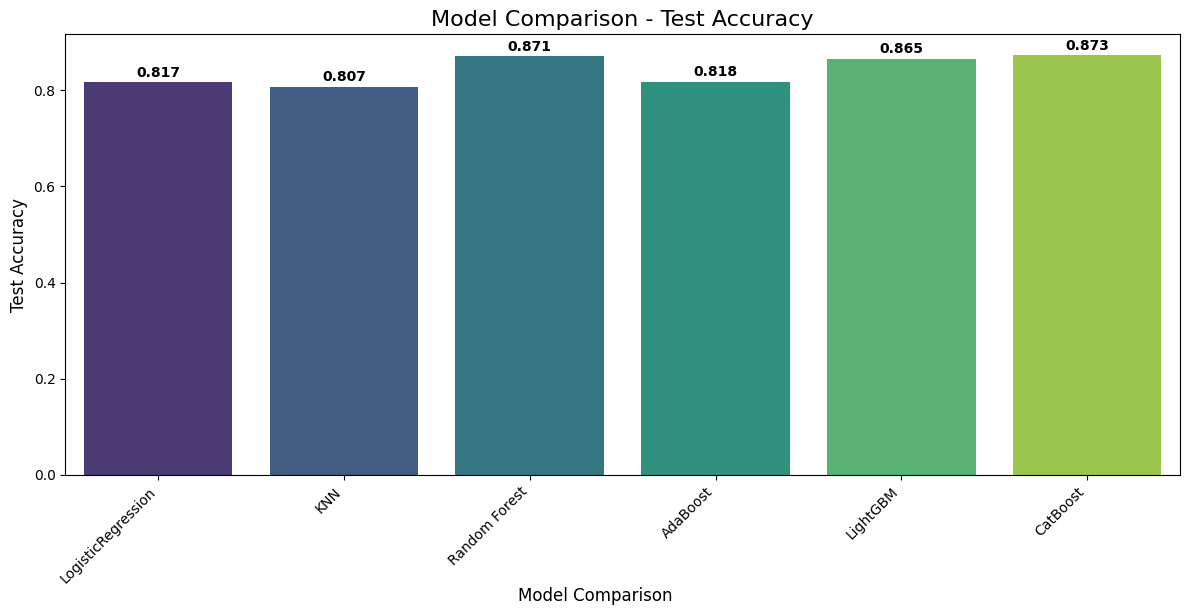

In [ ]:
plot_data = baseline_results_df.reset_index()

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Model', y='Test Accuracy', data=plot_data, palette='viridis', dodge=False)

plt.title('Model Comparison - Test Accuracy', fontsize=16)
plt.ylabel('Test Accuracy', fontsize=12)
plt.xlabel('')
plt.xticks(rotation=45, ha='right')

# Annotate bars with values
for i, v in enumerate(plot_data['Test Accuracy']):
    ax.text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.figtext(0.5, -0.01, 'Model Comparison', ha='center', fontsize=12)
plt.show()

In [ ]:
tuned_models = {
    "Logistic Regression": {
        'model': LogisticRegression(max_iter=1000,),
        'params': {
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga'],
            'fit_intercept': [True]
        }
    },

    "LightGBM": {
        'model': LGBMClassifier(verbose=-1),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.03, 0.05],
            'num_leaves': [15, 31],
            'max_depth': [3, 6],
            'reg_alpha': [0.0, 0.1],
            'reg_lambda': [0.0, 0.1],
            'boosting_type': ['gbdt']
        }
    },

    "KNN": {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    },

    "Random Forest": {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [6, 10],
            'min_samples_split': [5],
            'min_samples_leaf': [4],
            'max_features': ['sqrt'],
            'bootstrap': [True]
        }
    },

    "AdaBoost": {
        'model': AdaBoostClassifier(),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05],
            'algorithm': ['SAMME']
        }
    },

    "CatBoost": {
        'model': CatBoostClassifier(verbose=0),
        'params': {
            'iterations': [100, 200],
            'learning_rate': [0.03, 0.05],
            'depth': [3, 4],
            'l2_leaf_reg': [5, 10],
            'boosting_type': ['Ordered']
        }
    },
}


In [ ]:
def fit_and_evaluate_tuned_models(tuned_models, X_train_scaled, y_train_smote, X_test_scaled, y_test, n_iter=20):
    results = []
    trained_models = {}

    for name, model_info in tuned_models.items():
        print(f"\n Tuning and Training: {name}")

        model = model_info['model']
        param_distributions = model_info['params']

        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_distributions,
            n_iter=n_iter,
            cv=5,
            scoring='f1_macro',
            n_jobs=-1,
            random_state=42
        )

        random_search.fit(X_train_scaled, y_train)
        best_model = random_search.best_estimator_

        trained_models[name] = best_model

        y_train_pred = best_model.predict(X_train_scaled)
        y_test_pred = best_model.predict(X_test_scaled)

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        precision = precision_score(y_test, y_test_pred, average='weighted')
        recall = recall_score(y_test, y_test_pred, average='weighted')
        f1 = f1_score(y_test, y_test_pred, average='weighted')

        try:
            y_test_proba = best_model.predict_proba(X_test_scaled)
            if y_test_proba.shape[1] == 2:
                roc_auc = roc_auc_score(y_test, y_test_proba[:, 1])
            else:
                roc_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovr')
        except:
            roc_auc = "N/A"

        print(f"Best Parameters: {random_search.best_params_}")
        print(f"{name} - Test Accuracy: {test_acc:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc}")
        print("Classification Report:\n", classification_report(y_test, y_test_pred))

        results.append({
            "Model": name,
            "Train Accuracy": train_acc,
            "Test Accuracy": test_acc,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1,
            "ROC AUC": roc_auc
        })

    results_df = pd.DataFrame(results).set_index("Model").round(4)
    return results_df, trained_models


In [ ]:
tuned_results_df, trained_models = fit_and_evaluate_tuned_models(
    tuned_models,
    X_train_scaled,
    y_train_smote,
    X_test_scaled,
    y_test
)


 Tuning and Training: Logistic Regression
Best Parameters: {'solver': 'saga', 'penalty': 'l1', 'fit_intercept': True}
Logistic Regression - Test Accuracy: 0.8175, F1: 0.8162, ROC AUC: 0.9338342499576672
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89      4469
           1       0.87      0.86      0.86      4550
           2       0.65      0.62      0.63      2981

    accuracy                           0.82     12000
   macro avg       0.80      0.80      0.80     12000
weighted avg       0.82      0.82      0.82     12000


 Tuning and Training: LightGBM
Best Parameters: {'reg_lambda': 0.1, 'reg_alpha': 0.0, 'num_leaves': 31, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05, 'boosting_type': 'gbdt'}
LightGBM - Test Accuracy: 0.8664, F1: 0.8663, ROC AUC: 0.9661151412815298
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91     

In [ ]:
print("\nTuned Model Comparison:")
display(tuned_results_df)


Tuned Model Comparison:


Train Accuracy  Test Accuracy  Precision  Recall  \
Model                                                                   
Logistic Regression          0.8203         0.8175     0.8153  0.8175   
LightGBM                     0.8940         0.8664     0.8665  0.8664   
KNN                          1.0000         0.8370     0.8352  0.8370   
Random Forest                0.8754         0.8532     0.8504  0.8532   
AdaBoost                     0.7866         0.7887     0.7797  0.7887   
CatBoost                     0.8533         0.8501     0.8483  0.8501   

                     F1-score  ROC AUC  
Model                                   
Logistic Regression    0.8162   0.9338  
LightGBM               0.8663   0.9661  
KNN                    0.8358   0.9441  
Random Forest          0.8512   0.9579  
AdaBoost               0.7808   0.9153  
CatBoost               0.8489   0.9572

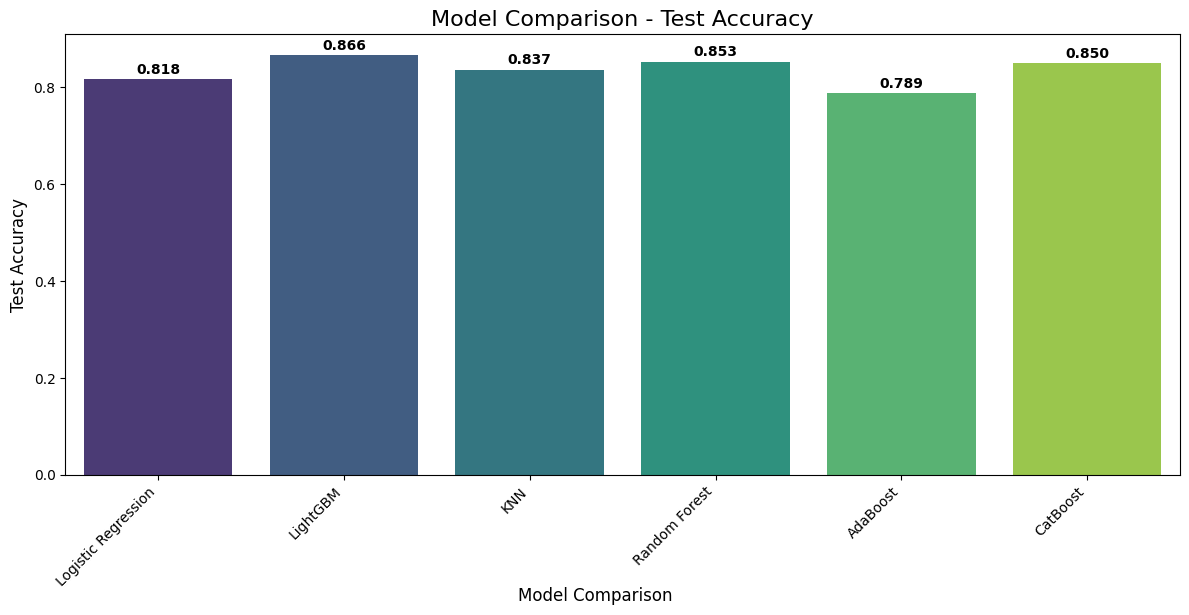

In [ ]:
plot_data_tuned = tuned_results_df.reset_index()

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Model', y='Test Accuracy', data=plot_data_tuned, palette='viridis', dodge=False)

plt.title('Model Comparison - Test Accuracy', fontsize=16)
plt.ylabel('Test Accuracy', fontsize=12)
plt.xlabel('')
plt.xticks(rotation=45, ha='right')

for i, v in enumerate(plot_data_tuned['Test Accuracy']):
    ax.text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.figtext(0.5, -0.01, 'Model Comparison', ha='center', fontsize=12)
plt.show()

In [ ]:
LightGBM = trained_models.get("LightGBM")
best_model = trained_models["LightGBM"]

Feature Importance Analysis

Understanding which features most strongly influence predictions helps with model interpretability. The plot below shows the top features ranked by importance in the LightGBM model.

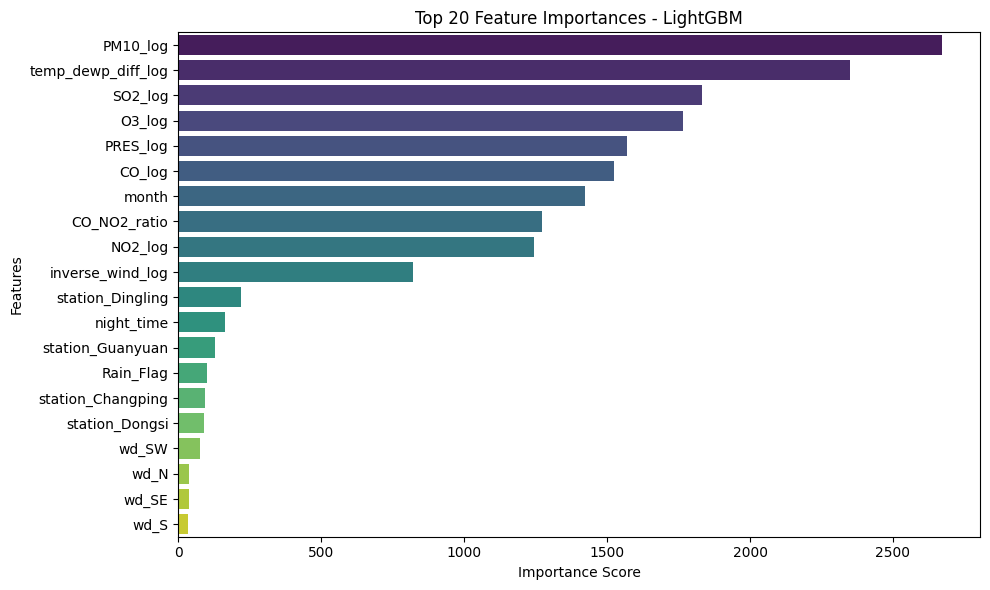

In [ ]:
model_name = "LightGBM"
model = trained_models[model_name]

feature_names = final_feature_names

if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=importances[indices][:20],
        y=np.array(feature_names)[indices][:20],
        palette='viridis'
    )
    plt.title(f"Top 20 Feature Importances - {model_name}")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()

elif hasattr(model, 'coef_'):
    coefs = model.coef_
    if coefs.ndim > 1:
        coefs = np.mean(coefs, axis=0)
    indices = np.argsort(np.abs(coefs))[::-1]

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=coefs[indices][:20],
        y=np.array(feature_names)[indices][:20],
        palette='coolwarm'
    )
    plt.title(f"Top 20 Coefficients - {model_name}")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()

else:
    print(f"⚠️ {model_name} does not support feature importance or coefficients.")

In [ ]:
def plot_confusion_matrix_weather(model, X_test_scaled, y_test, model_name="LightGBM"):
    """
    Generate and display the confusion matrix for a trained model.
    """
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)

    unique_classes = np.unique(np.concatenate((y_test, y_pred)))
    class_labels = [f"{cls} (Class)" for cls in unique_classes]

    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5, cbar=False)

    ax.set_title(f'{model_name} - Confusion Matrix (Test Data)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('Actual Label', fontsize=12)

    ax.set_xticklabels(class_labels, fontsize=10)
    ax.set_yticklabels(class_labels, fontsize=10)

    plt.subplots_adjust(bottom=0.25)
    plt.figtext(0.5, -0.01, "Confusion Matrix", ha='center', fontsize=12)

    plt.show()


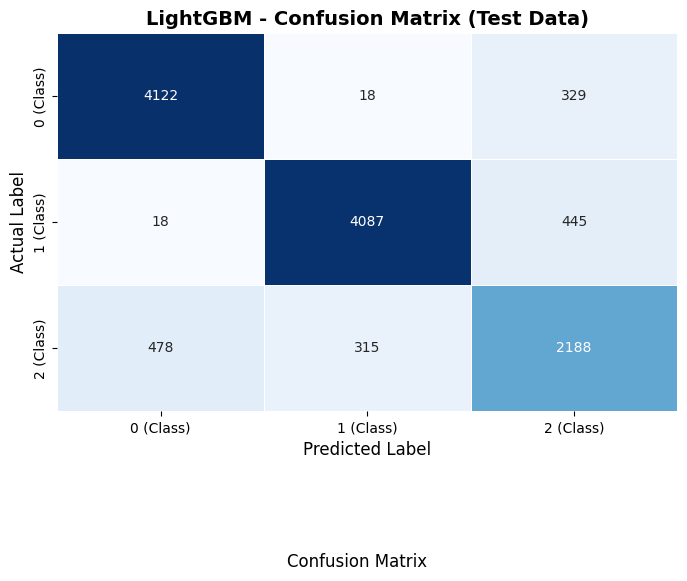

In [ ]:
plot_confusion_matrix_weather(trained_models["LightGBM"], X_test_scaled, y_test, "LightGBM")

In [ ]:
X_test_scaled.shape

(12000, 30)

In [ ]:
with open('LightGBM.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [ ]:
with open('StandardScalar.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# SHapley Additive exPlanations (SHAP)

In [ ]:
with open("LightGBM.pkl", "rb") as f:
    best_model = pickle.load(f)

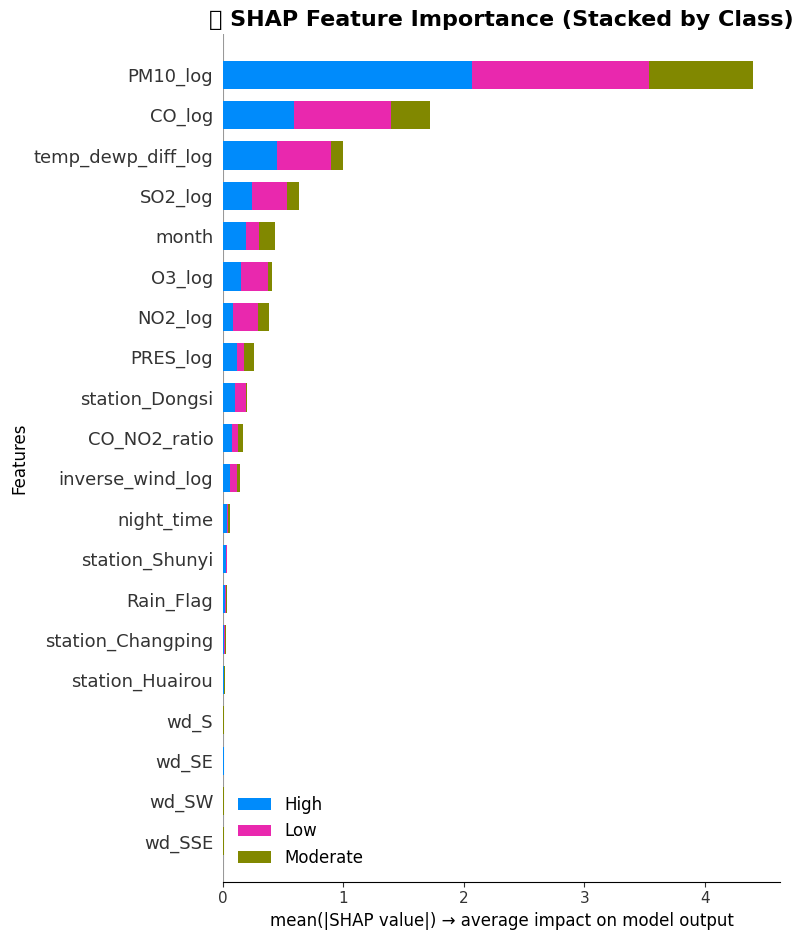

In [ ]:
X_test_df = pd.DataFrame(X_test_scaled, columns=final_feature_names).astype(float)

explainer = shap.Explainer(best_model)
shap_values = explainer(X_test_df)

plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values,
    X_test_df,
    feature_names=final_feature_names,
    plot_type="bar",
    class_names=["High", "Low", "Moderate"],
    show=False
)

plt.title("🔍 SHAP Feature Importance (Stacked by Class)", fontsize=16, weight='bold')
plt.xlabel("mean(|SHAP value|) → average impact on model output", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()

plt.savefig("shap_summary_stacked_bar.png", dpi=300)
plt.show()